In questo script ci sono 3 punti essenziali da risolvere:
1) Risultati datasets cerchi
2) Risultati datasets parabole
3) Risultati datasets tulipani
4) Risultati dataset reali con paragone al variare di iperparametri

Nel calcolo delle metriche aggiungere Gap statistic e entropia di Shannon. Per entropia di Shannon e Davies-Bouldin, bisogna normalizzare con i reciprochi.

Gap Statistics determina il numero ottimale di cluster. DBSCAN non necessita di un numero fisso di cluster come parametro in input perchè forma i cluster in base a criteri di densità.

**1)Provare ad usare GapStatistics**

**2)Grafici
Inserire numero di cluster nel grafico delle metriche
INserire la griglia
Inserire Reciproco e normalizzato nei grafici**

3)Inserire tulipano con punti piu raggruppati

4)**COn dataset reali:
uso DBSCAN, hdbscan e mean-shift. Se una riga viene messo nel cluster X da tutti e 3 allora questa la consideriamo verità. I pazienti inseriti nello stesso cluster da tutti e 3 vengono considerati "corretti". I punti non corretti li classifichiamo come rumore e poi calcoliamo le varie metriche.
La metrica deve avvicinarsi il piu possibile alla percentuale**

5)Per ogni dataset:
Percentuale di righe classificate correttamente.
calcolare le metriche utilizzate per dataset artificiali e confrontrarle con la percentuale.
Nei casi in cui la metrica è infinta --> Error Function

**6)verificare entropia**

7)preprocessing.  normalizzazione, rimozione colonne id.




#**Library**

In [1]:
pip install "git+https://github.com/FelSiq/DBCV"


  Cloning https://github.com/FelSiq/DBCV to /tmp/pip-req-build-9rtuwcz7
  Running command git clone --filter=blob:none --quiet https://github.com/FelSiq/DBCV /tmp/pip-req-build-9rtuwcz7
  Resolved https://github.com/FelSiq/DBCV to commit 69d930f337b526985af84b1fb83a880b794e38c6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dbcv: filename=dbcv-0.1.0-py3-none-any.whl size=6505 sha256=b62f53358bb802a38635d4a3d2be3daacf2c20cc62f772522ecc9abc46163090
  Stored in directory: /tmp/pip-ephem-wheel-cache-f7lne264/wheels/db/29/5c/22f8798fd788b7f37312b81a63fab3aa43bea8270f453fbe8c
Successfully built dbcv


In [2]:
from dbcv import dbcv

In [3]:
pip install "git+https://github.com/christopherjenness/DBCV"

  Cloning https://github.com/christopherjenness/DBCV to /tmp/pip-req-build-zezft51s
  Running command git clone --filter=blob:none --quiet https://github.com/christopherjenness/DBCV /tmp/pip-req-build-zezft51s
  Resolved https://github.com/christopherjenness/DBCV to commit db7345c45ab7d33ea500778e5c9048fd9f7d3156
  Preparing metadata (setup.py) ... done
  Created wheel for DBCV: filename=DBCV-0.0.0-py3-none-any.whl size=4186 sha256=6eece204e952f2b7b271735eb2d8d14643de0e4b99b3e8d5dbb146785742afd4
  Stored in directory: /tmp/pip-ephem-wheel-cache-qer8f3ws/wheels/f7/06/e3/54e0af644dd9ff7b28d7ab4f6f628804ee3c0a86c8f835c749
Successfully built DBCV
  Attempting uninstall: DBCV
    Found existing installation: dbcv 0.1.0
    Uninstalling dbcv-0.1.0:
      Successfully uninstalled dbcv-0.1.0


In [4]:
pip install scikit-learn hdbscan matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 46.4 MB/s eta 0:00:00


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
import hdbscan
import time
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from DBCV import DBCV
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score,adjusted_rand_score , davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN
from sklearn.utils import resample
from scipy.stats import entropy
import math
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.utils import resample
import scipy.io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)



a.spagnolo9@campus.unimib.ii

#**Function**

In [6]:
def optimalK(data, maxClusters):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarray of shape (n_samples, n_features)
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    nrefs = 3
    gaps = np.zeros((len(range(1, maxClusters)),))
    results = []

    for gap_index, k in enumerate(range(1, maxClusters)):

        refDisps = np.zeros(nrefs)

        for i in range(nrefs):
            randomReference = np.random.random_sample(size=data.shape)
            km = KMeans(n_clusters=k)
            km.fit(randomReference)

            refDisp = km.inertia_
            refDisps[i] = refDisp
        km = KMeans(n_clusters=k)
        km.fit(data)

        origDisp = km.inertia_

        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        gaps[gap_index] = gap
        results.append({'clusterCount': k, 'gap': gap})
    resultsdf = pd.DataFrame(results)
    return gaps.argmax() + 1, resultsdf

In [7]:
def generate_moon_datasets(seed):
    datasets = []

    for noise in [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]:
        X, _ = make_moons(n_samples=1000, noise=noise, random_state=seed)
        datasets.append(X)

    return datasets

In [8]:
def plot_datasets(datasets):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    for i, dataset in enumerate(datasets):
        row = i // 5
        col = i % 5
        ax = axes[row, col]
        ax.scatter(dataset[:, 0], dataset[:, 1], c='black', s=1)
        ax.set_title(f'Dataset {i+1}')
        ax.set_xlim(-1.5, 2.5)
        ax.set_ylim(-1.0, 1.5)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
def plot_best_results_compare(datasets, results, best_params):
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    min_samples, epsilon = best_params

    for i, (X, dataset_results) in enumerate(zip(datasets, results)):
        print(dataset_results)
        for min_samples_, epsilon_, dbcv_score, silhouette, dunn_index, davies_bouldin, calinski_harabasz,shannon_entropy, labels in dataset_results:
            if (min_samples_, epsilon_) == best_params:
                ax = axs[i // 5, i % 5]
                ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
                ax.set_title(f'min_samples={min_samples}, epsilon={epsilon}\ndbcv={dbcv_score:.3f}\nsilhouette={silhouette:.3f}\ndunn={dunn_index:.3f}\ndavies={davies_bouldin:.3f}\ncalinski={calinski_harabasz:.3f}\nshannon_entropy={shannon_entropy:.3f}')
                ax.set_xticks([])
                ax.set_yticks([])
                break

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [51]:
def calculate_dunn_index(X, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return -1

    distances = np.sqrt(((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2).sum(axis=2))
    min_intercluster_distances = np.inf
    for label_i in unique_labels:
        cluster_i = X[labels == label_i]
        for label_j in unique_labels:
            if label_i != label_j:
                cluster_j = X[labels == label_j]
                intercluster_distances = np.min(distances[np.ix_(labels == label_i, labels == label_j)])
                min_intercluster_distances = min(min_intercluster_distances, intercluster_distances)
    max_intracluster_distances = 0
    for label in unique_labels:
        cluster = X[labels == label]
        intracluster_distances = np.max(distances[np.ix_(labels == label, labels == label)])
        max_intracluster_distances = max(max_intracluster_distances, intracluster_distances)
    return min_intercluster_distances / max_intracluster_distances



In [11]:
def analyze_datasets(datasets):
    results = []
    param_grid = {
        'min_samples': [10],
        'epsilon': [0.1]
    }

    for X in datasets:
        dataset_results = []
        for min_samples in param_grid['min_samples']:
            for epsilon in param_grid['epsilon']:
                clusterer = DBSCAN(min_samples=min_samples, eps=epsilon)
                #clusterer = hdbscan.HDBSCAN(min_samples = min_samples, cluster_selection_epsilon=epsilon)
                labels = clusterer.fit_predict(X)

                dbcv_score = dbcv(X, labels)
                silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
                dunn_index = calculate_dunn_index(X, labels)
                davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
                calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
                shannon_entropy = calculate_shannon_entropy(labels)
                dataset_results.append((min_samples, epsilon, dbcv_score, silhouette, dunn_index,
                                        davies_bouldin, calinski_harabasz, shannon_entropy, labels))

        results.append(dataset_results)

    return results

In [12]:
def analyze_datasets_best_params(datasets):
    results = []
    param_grid = {
        'min_samples': [1, 5, 10, 50],
        'epsilon': [0.01, 0.1, 0.2, 0.5]
    }

    for X in datasets:
        dataset_results = []

        for min_samples in param_grid['min_samples']:
            for epsilon in param_grid['epsilon']:
                clusterer = DBSCAN(min_samples=min_samples, eps=epsilon)
                labels = clusterer.fit_predict(X)
                dbcv_score = dbcv(X, labels)
                dataset_results.append((min_samples, epsilon, dbcv_score,labels))

        results.append(dataset_results)

    return results

In [13]:
def find_best_params(results):
    param_dbvcs = {}

    for dataset_results in results:
        for min_samples, epsilon, dbcv_score, labels in dataset_results:
            param_key = (min_samples, epsilon)
            if param_key not in param_dbvcs:
                param_dbvcs[param_key] = []
            param_dbvcs[param_key].append(dbcv_score)

    param_avg_dbcv = {k: np.mean(v) for k, v in param_dbvcs.items()}

    best_params = max(param_avg_dbcv, key=param_avg_dbcv.get)

    return best_params

In [14]:
import matplotlib.pyplot as plt

def plot_best_results(datasets, results, best_params):
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    min_samples, epsilon = best_params
    min_samples = 2
    epsilon = 0.1

    for i, (X, dataset_results) in enumerate(zip(datasets, results)):
        for min_samples_, epsilon_, dbcv_score, labels in dataset_results:
            if (min_samples_, epsilon_) == best_params:
                ax = axs[i // 5, i % 5]
                ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
                if dbcv_score is not None:
                    ax.set_title(f'min_samples={min_samples}, epsilon={epsilon}\ndbcv={dbcv_score:.3f}')
                else:
                    ax.set_title(f'min_samples={min_samples}, epsilon={epsilon}\ndbcv=N/A')
                ax.set_xticks([])
                ax.set_yticks([])
                break

    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
def calculate_shannon_entropy(labels):
    unique, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    # labels = labels + 1
    # entropy_val = entropy(np.bincount(labels) / len(labels), base=2)
    # entropy_val = abs(1-entropy_val)
    return entropy

In [16]:
def plot_datasets_with_clustering(datasets):
    fig, axes = plt.subplots(10, 3, figsize=(18, 30))
    dbcv_total = []
    dunn_total = []
    davies_total = []
    calinski_total = []
    entropy_total = []
    silhouette_total = []
    gap_total = []

    for i, dataset in enumerate(datasets):
        X = dataset

        ax_left = axes[i, 0]
        ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
        ax_left.set_title(f'Dataset {i+1} - Original')
        ax_left.set_xlim(-1.5, 2.5)
        ax_left.set_ylim(-1.0, 1.5)
        ax_left.grid(True, color='lightgrey', linewidth=0.5)

        ax_middle = axes[i, 1]
        clusterer = DBSCAN(min_samples=10, eps=0.1)
        labels = clusterer.fit_predict(X)

        scatter = ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
        ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
        ax_middle.set_xlim(-1.5, 2.5)
        ax_middle.set_ylim(-1.0, 1.5)
        ax_middle.grid(True, color='lightgrey', linewidth=0.5)

        dbcv_score = dbcv(X, labels)
        dbcv_total.append(dbcv_score)
        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        silhouette_total.append(silhouette)
        dunn_index = calculate_dunn_index(X, labels)
        dunn_total.append(dunn_index)
        davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
        davies_bouldin_norm = 1 / davies_bouldin if davies_bouldin > 0 else -1
        davies_total.append(davies_bouldin_norm)

        calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
        calinski_total.append(calinski_harabasz)

        # Calcolo entropia e normalizzazione
        num_clusters = len(set(labels))
        entropy = calculate_shannon_entropy(labels)
        shannon_entropy_norm = abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1
        entropy_total.append(shannon_entropy_norm)
        n_clusters,gap_df = optimalK(X, 20)
        optimal_gap_statistic = gap_df.loc[gap_df.gap.idxmax(), 'gap']
        gap_total.append(optimal_gap_statistic)


        ax_right = axes[i, 2]
        ax_right.axis('off')

        metrics_text = (f'DBCV: {round(float(dbcv_score),4)}\n'
                        f'Silhouette: {round(float(silhouette),4)}\n'
                        f'Dunn Index: {round(float(dunn_index),4)}\n'
                        f'Davies-Bouldin (Rec): {round(float(davies_bouldin_norm),4)}\n'
                        f'Calinski-Harabasz: {round(float(calinski_harabasz),4)}\n'
                        f'Entropy (Norm): {round(float(shannon_entropy_norm),4)}\n'
                        f'Gap Statistic: {round(float(optimal_gap_statistic),4)}\n'
                        f'Number of clusters: {len(set(labels))}')

        ax_right.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
                      bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()
    return dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total,gap_total


In [17]:
def generate_circle_data(n_points, radius, shift):
    t = np.linspace(0, 2 * np.pi, n_points)
    x = radius * np.cos(t) + shift[0]
    y = radius * np.sin(t) + shift[1]
    return np.column_stack((x, y))

In [18]:
def generate_datasets_with_two_circles(n_datasets, n_points_per_circle, n_points_per_circle_inner, inner_radius, outer_radius, initial_shift, shift_increment):
    datasets = []
    for i in range(n_datasets):
        outer_circle = generate_circle_data(n_points_per_circle, outer_radius, (0, 0))

        shift = (initial_shift[0] + i * shift_increment[0], initial_shift[1] + i * shift_increment[1])
        inner_circle = generate_circle_data(n_points_per_circle_inner, inner_radius, shift)

        dataset = np.concatenate([outer_circle, inner_circle])
        datasets.append(dataset)
    return datasets


In [19]:
def plot_datasets_with_clustering_circle(datasets):
    fig, axes = plt.subplots(10, 3, figsize=(30, 50))
    dbcv_total = []
    dunn_total = []
    davies_total = []
    calinski_total = []
    entropy_total = []
    silhouette_total = []
    gap_total = []

    for i, dataset in enumerate(datasets):
        X = np.unique(dataset, axis=0)

        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

        ax_left = axes[i, 0]
        ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
        ax_left.set_title(f'Dataset {i+1} - Original')
        ax_left.set_xlim(x_min, x_max)
        ax_left.set_ylim(y_min, y_max)
        ax_left.set_aspect('equal')
        ax_left.grid(True, color='lightgrey', linewidth=0.5)  # Griglia chiara e sottile

        ax_middle = axes[i, 1]
        clusterer = DBSCAN(eps=0.1, min_samples=20)
        labels = clusterer.fit_predict(X)

        scatter = ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
        ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
        ax_middle.set_xlim(x_min, x_max)
        ax_middle.set_ylim(y_min, y_max)
        ax_middle.set_aspect('equal')
        ax_middle.grid(True, color='lightgrey', linewidth=0.5)  # Griglia chiara e sottile

        try:
            dbcv_score = dbcv(X, labels)
        except ValueError:
            dbcv_score = DBCV(X, labels)
        dbcv_total.append(dbcv_score)

        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        silhouette_total.append(silhouette)
        dunn_index = calculate_dunn_index(X, labels)
        dunn_total.append(dunn_index)

        davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
        davies_bouldin_norm = 1 / davies_bouldin if davies_bouldin > 0 else -1
        davies_total.append(davies_bouldin_norm)

        calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
        calinski_total.append(calinski_harabasz)

        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        entropy = calculate_shannon_entropy(labels)
        shannon_entropy_norm = abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1
        entropy_total.append(shannon_entropy_norm)

        n_clusters,gap_df = optimalK(X, 20)
        optimal_gap_statistic = gap_df.loc[gap_df.gap.idxmax(), 'gap']
        gap_total.append(optimal_gap_statistic)

        ax_right = axes[i, 2]
        ax_right.axis('off')

        metrics_text = (f'DBCV: {round(float(dbcv_score),4)}\n'
                        f'Silhouette: {round(float(silhouette),4)}\n'
                        f'Dunn Index: {round(float(dunn_index),4)}\n'
                        f'Davies-Bouldin (Rec): {round(float(davies_bouldin_norm),4)}\n'
                        f'Calinski-Harabasz: {round(float(calinski_harabasz),4)}\n'
                        f'Entropy (Norm): {round(float(shannon_entropy_norm),4)}\n'
                        f'Gap Statistic: {round(float(optimal_gap_statistic),4)}\n'
                        f'Number of clusters: {len(set(labels))}')

        ax_right.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
                      bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()
    return dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total


In [20]:
def generate_noisy_circles(n_datasets, n_samples, noise_increment, seed):
    datasets = []
    for i in range(n_datasets):
        noise_level = 0.05 + i * noise_increment
        noisy_circles = make_circles(n_samples=n_samples, factor=0.5, noise=noise_level, random_state=seed)
        datasets.append(noisy_circles[0])
    return datasets

In [21]:
def plot_datasets_with_clustering_noisy_circles(datasets):
    fig, axes = plt.subplots(10, 3, figsize=(30, 50))
    dbcv_total = []
    dunn_total = []
    davies_total = []
    calinski_total = []
    entropy_total = []
    silhouette_total = []
    gap_total = []

    for i, dataset in enumerate(datasets):
        X = np.unique(dataset, axis=0)

        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

        ax_left = axes[i, 0]
        ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
        ax_left.set_title(f'Dataset {i+1} - Original')
        ax_left.set_xlim(x_min, x_max)
        ax_left.set_ylim(y_min, y_max)
        ax_left.set_aspect('equal')
        ax_left.grid(True, color='lightgrey', linewidth=0.5)

        ax_middle = axes[i, 1]
        clusterer = DBSCAN(eps=0.1, min_samples=10)
        labels = clusterer.fit_predict(X)

        scatter = ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
        ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
        ax_middle.set_xlim(x_min, x_max)
        ax_middle.set_ylim(y_min, y_max)
        ax_middle.set_aspect('equal')
        ax_middle.grid(True, color='lightgrey', linewidth=0.5)

        try:
            dbcv_score = dbcv(X, labels)
        except ValueError:
            dbcv_score = DBCV(X, labels)
        dbcv_total.append(dbcv_score)

        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        silhouette_total.append(silhouette)

        dunn_index = calculate_dunn_index(X, labels)
        dunn_total.append(dunn_index)

        davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
        davies_bouldin_norm = 1 / davies_bouldin if davies_bouldin > 0 else -1
        davies_total.append(davies_bouldin_norm)

        calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
        calinski_total.append(calinski_harabasz)

        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        entropy = calculate_shannon_entropy(labels)
        shannon_entropy_norm = abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1
        entropy_total.append(shannon_entropy_norm)

        n_clusters,gap_df = optimalK(X, 20)
        optimal_gap_statistic = gap_df.loc[gap_df.gap.idxmax(), 'gap']
        gap_total.append(optimal_gap_statistic)

        ax_right = axes[i, 2]
        ax_right.axis('off')

        metrics_text = (f'DBCV: {round(float(dbcv_score), 4)}\n'
                        f'Silhouette: {round(float(silhouette), 4)}\n'
                        f'Dunn Index: {round(float(dunn_index), 4)}\n'
                        f'Davies-Bouldin (Rec): {round(float(davies_bouldin_norm), 4)}\n'
                        f'Calinski-Harabasz: {round(float(calinski_harabasz), 4)}\n'
                        f'Entropy (Norm): {round(float(shannon_entropy_norm), 4)}\n'
                        f'Gap Statistic: {round(float(optimal_gap_statistic),4)}\n'
                        f'Number of clusters: {len(set(labels))}')

        ax_right.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
                      bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()
    return dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total


In [22]:
def generate_augmented_datasets(seed):
    datasets = []
    noise_levels = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]

    for noise in noise_levels:
        np.random.seed(seed)
        num_new_points = 400
        new_points = normalized_points[np.random.choice(normalized_points.shape[0], num_new_points)]
        noisy_new_points = new_points + np.random.normal(0, noise, (num_new_points, 2))

        noisy_new_points = noisy_new_points % 1

        augmented_data = np.vstack((normalized_points, noisy_new_points))
        datasets.append(augmented_data)

    return datasets


In [23]:
def analyze_datasets_tulipan(datasets):
    results = []
    for X in datasets:
        dataset_results = []
        min_samples, epsilon = 35, 0.1
        clusterer = DBSCAN(min_samples=min_samples, eps=epsilon)
        labels = clusterer.fit_predict(X)

        dbcv_score = DBCV(X, labels)
        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        dunn_index = calculate_dunn_index(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
        davies_bouldin = 1 / davies_bouldin if davies_bouldin > 0 else -1
        calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
        num_clusters = len(set(labels))
        shannon_entropy = calculate_shannon_entropy(labels)
        shannon_entropy = abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1
        n_clusters,gap_df = optimalK(X, 20)
        optimal_gap_statistic = gap_df.loc[gap_df.gap.idxmax(), 'gap']


        dataset_results.append((dbcv_score, silhouette, dunn_index, davies_bouldin, calinski_harabasz, shannon_entropy, optimal_gap_statistic, labels))
        results.append(dataset_results)

    return results

In [24]:
def plot_datasets_with_clustering_tulipan(datasets, results):
    fig, axes = plt.subplots(10, 3, figsize=(18, 30))
    dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total,gap_total = [], [], [], [], [], [], []

    for i, (dataset, metrics) in enumerate(zip(datasets, results)):
        X = dataset
        dbcv_score, silhouette, dunn_index, davies_bouldin, calinski_harabasz, shannon_entropy, optimal_gap_statistic, labels = metrics[0]
        ax_left = axes[i, 0]
        ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
        ax_left.set_title(f'Dataset {i+1} - Original')
        ax_left.set_xlim(-0.1, 1.1)
        ax_left.set_ylim(-0.1, 1.1)
        ax_left.grid(True, color='lightgrey', linewidth=0.5)

        ax_middle = axes[i, 1]
        ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
        ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
        ax_middle.set_xlim(-0.1, 1.1)
        ax_middle.set_ylim(-0.1, 1.1)
        ax_middle.grid(True, color='lightgrey', linewidth=0.5)

        ax_right = axes[i, 2]
        ax_right.axis('off')
        metrics_text = (f'DBCV: {round(dbcv_score, 4)}\n'
                        f'Silhouette: {round(silhouette, 4)}\n'
                        f'Dunn Index: {round(dunn_index, 4)}\n'
                        f'Davies-Bouldin (Rec): {round(1 / davies_bouldin if davies_bouldin > 0 else -1, 4)}\n'
                        f'Calinski-Harabasz: {round(calinski_harabasz, 4)}\n'
                        f'Entropy (Norm): {round(shannon_entropy, 4)}\n'
                        f'Gap Statistic: {round(float(optimal_gap_statistic),4)}\n'
                        f'Number of clusters: {len(set(labels))}')
        ax_right.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))

        dbcv_total.append(dbcv_score)
        silhouette_total.append(silhouette)
        dunn_total.append(dunn_index)
        davies_total.append(1 / davies_bouldin if davies_bouldin > 0 else -1)
        calinski_total.append(calinski_harabasz)
        entropy_total.append(shannon_entropy)
        gap_total.append(optimal_gap_statistic)

    plt.tight_layout()
    plt.show()
    return dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total


In [57]:
def best_params_hdbscan(df):
  min_cluster_sizes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15]
  cluster_selection_epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5]

  best_dbcv_score = -1
  best_params = None
  best_labels = None

  for min_cluster_size in min_cluster_sizes:
    for epsilon in cluster_selection_epsilons:

        dbscan_pca = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                             cluster_selection_epsilon=epsilon)

        labels = dbscan_pca.fit_predict(df)

        if len(set(labels)) > 1:
            dbcv_score = dbcv(df, labels)

            if dbcv_score > best_dbcv_score:
                best_dbcv_score = dbcv_score
                best_params = (min_cluster_size, epsilon)
                best_labels = labels


  print(f"min_cluster_size: {best_params[0]}, cluster_selection_epsilon: {best_params[1]}")

  return best_params[0],best_params[1]

In [58]:
def best_params_dbscan(df):
  min_cluster_sizes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15]
  cluster_selection_epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5]

  best_dbcv_score = -1
  best_params = None
  best_labels = None

  for min_cluster_size in min_cluster_sizes:
    for epsilon in cluster_selection_epsilons:

        dbscan_pca = DBSCAN(min_samples=min_cluster_size,
                             eps=epsilon)

        labels = dbscan_pca.fit_predict(df)

        if len(set(labels)) > 1:
            dbcv_score = dbcv(df, labels)

            if dbcv_score > best_dbcv_score:
                best_dbcv_score = dbcv_score
                best_params = (min_cluster_size, epsilon)
                best_labels = labels

  print(f"min_cluster_size: {best_params[0]}, cluster_selection_epsilon: {best_params[1]}")
  return best_params[0], best_params[1]

In [59]:
def best_params_mean_shift(df):
  bandwidth_estimate = estimate_bandwidth(df, quantile=0.2, n_samples=500)
  bandwidth_range = np.linspace(bandwidth_estimate * 0.1, bandwidth_estimate * 1.9, 10)
  best_bandwidth = None
  best_score = -np.inf

  for bandwidth in bandwidth_range:
    ms = MeanShift(bandwidth=bandwidth)
    labels = ms.fit_predict(df)

    if len(set(labels)) > 1:
        try:

            dbcv_score = dbcv(df, labels)
            if dbcv_score > best_score:
                best_score = dbcv_score
                best_bandwidth = bandwidth
        except ValueError as e:
            print(f"Errore calcolando DBCV per banda {round(bandwidth,3)}: {e}")
    else:
        print(f"Banda {bandwidth} genera solo un cluster. Ignorato.")

  print(f"Best bandwidth: {round(best_bandwidth,3)}")
  return best_bandwidth

In [28]:
def similar_cluster(df):
  valori_unici_ms = df["Mean_shift_pred"].unique()
  valori_unici_db = df["DBSCAN_pred"].unique()
  valori_unici_hdb = df["HDBSCAN_pred"].unique()
  print(valori_unici_ms)
  print(valori_unici_db)
  print(valori_unici_hdb)

  mean_shift_labels = valori_unici_ms
  dbscan_labels = valori_unici_db
  hdbscan_labels = valori_unici_hdb
  total_rows = len(df)

  result = []

  for mean_label in mean_shift_labels:
    for dbscan_label in dbscan_labels:
        for hdbscan_label in hdbscan_labels:

            mask = (df['Mean_shift_pred'] == mean_label) & \
                   (df['DBSCAN_pred'] == dbscan_label) & \
                   (df['HDBSCAN_pred'] == hdbscan_label)
            count = mask.sum()
            percentage = (count / total_rows) * 100
            result.append({
                'Mean_shift': mean_label,
                'DBSCAN': dbscan_label,
                'HDBSCAN': hdbscan_label,
                'Percentuale': percentage
            })
  result_df = pd.DataFrame(result)
  result_df = result_df.sort_values(by='Percentuale', ascending=False)
  return result_df
# MAssimo X abbinamenti perche cluster con meno label ha solo X cluster, quindi sicuramente non ci possono
# essere piu abbinamenti di X abbinamenti di cluster corretti. Sono stati selezionati quelli che hanno
# fornito una percentuale maggiore escludendo cluster gia selezionati


In [29]:
def compute_ari(df):
  ariAbs1 = abs(adjusted_rand_score(neuroblastoma_scaled["DBSCAN_pred"], neuroblastoma_scaled["HDBSCAN_pred"]))
  ariAbs2 = abs(adjusted_rand_score(neuroblastoma_scaled["HDBSCAN_pred"], neuroblastoma_scaled["Mean_shift_pred"]))
  ariAbs3 = abs(adjusted_rand_score(neuroblastoma_scaled["Mean_shift_pred"], neuroblastoma_scaled["DBSCAN_pred"]))

  ariAbsAverage = (ariAbs1 + ariAbs2 + ariAbs3) / 3
  return ariAbsAverage

In [104]:
def compute_metrics(X, labels):
  dbcv_score = round((dbcv(X, labels)),2)
  silhouette = round((silhouette_score(X, labels) if len(set(labels)) > 1 else -1),2)
  dunn_index = 0 #calculate_dunn_index(X, labels)
  davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
  davies_bouldin_norm = round((1 / davies_bouldin if davies_bouldin > 0 else -1),2)
  calinski_harabasz = round((calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1),2)
  num_clusters = len(set(labels))
  entropy = calculate_shannon_entropy(labels)
  shannon_entropy_norm = round((abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1),2)
  n_clusters,gap_df = optimalK(X, 20)
  optimal_gap_statistic = round((gap_df.loc[gap_df.gap.idxmax(), 'gap']),2)

  return dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic

#**Find Best Params**

In [ ]:
# start_time = time.time()
# datasets = generate_moon_datasets()
# results = analyze_datasets_best_params(datasets)
# best_params = find_best_params(results)
# plot_best_results(datasets, results, best_params)
# end_time = time.time()

# print(f"Tempo totale di esecuzione: {end_time - start_time:.2f} secondi")


#**Artificial Dataset**

**Moons**

Eseguito su 1000 campioni con fastdbcv.

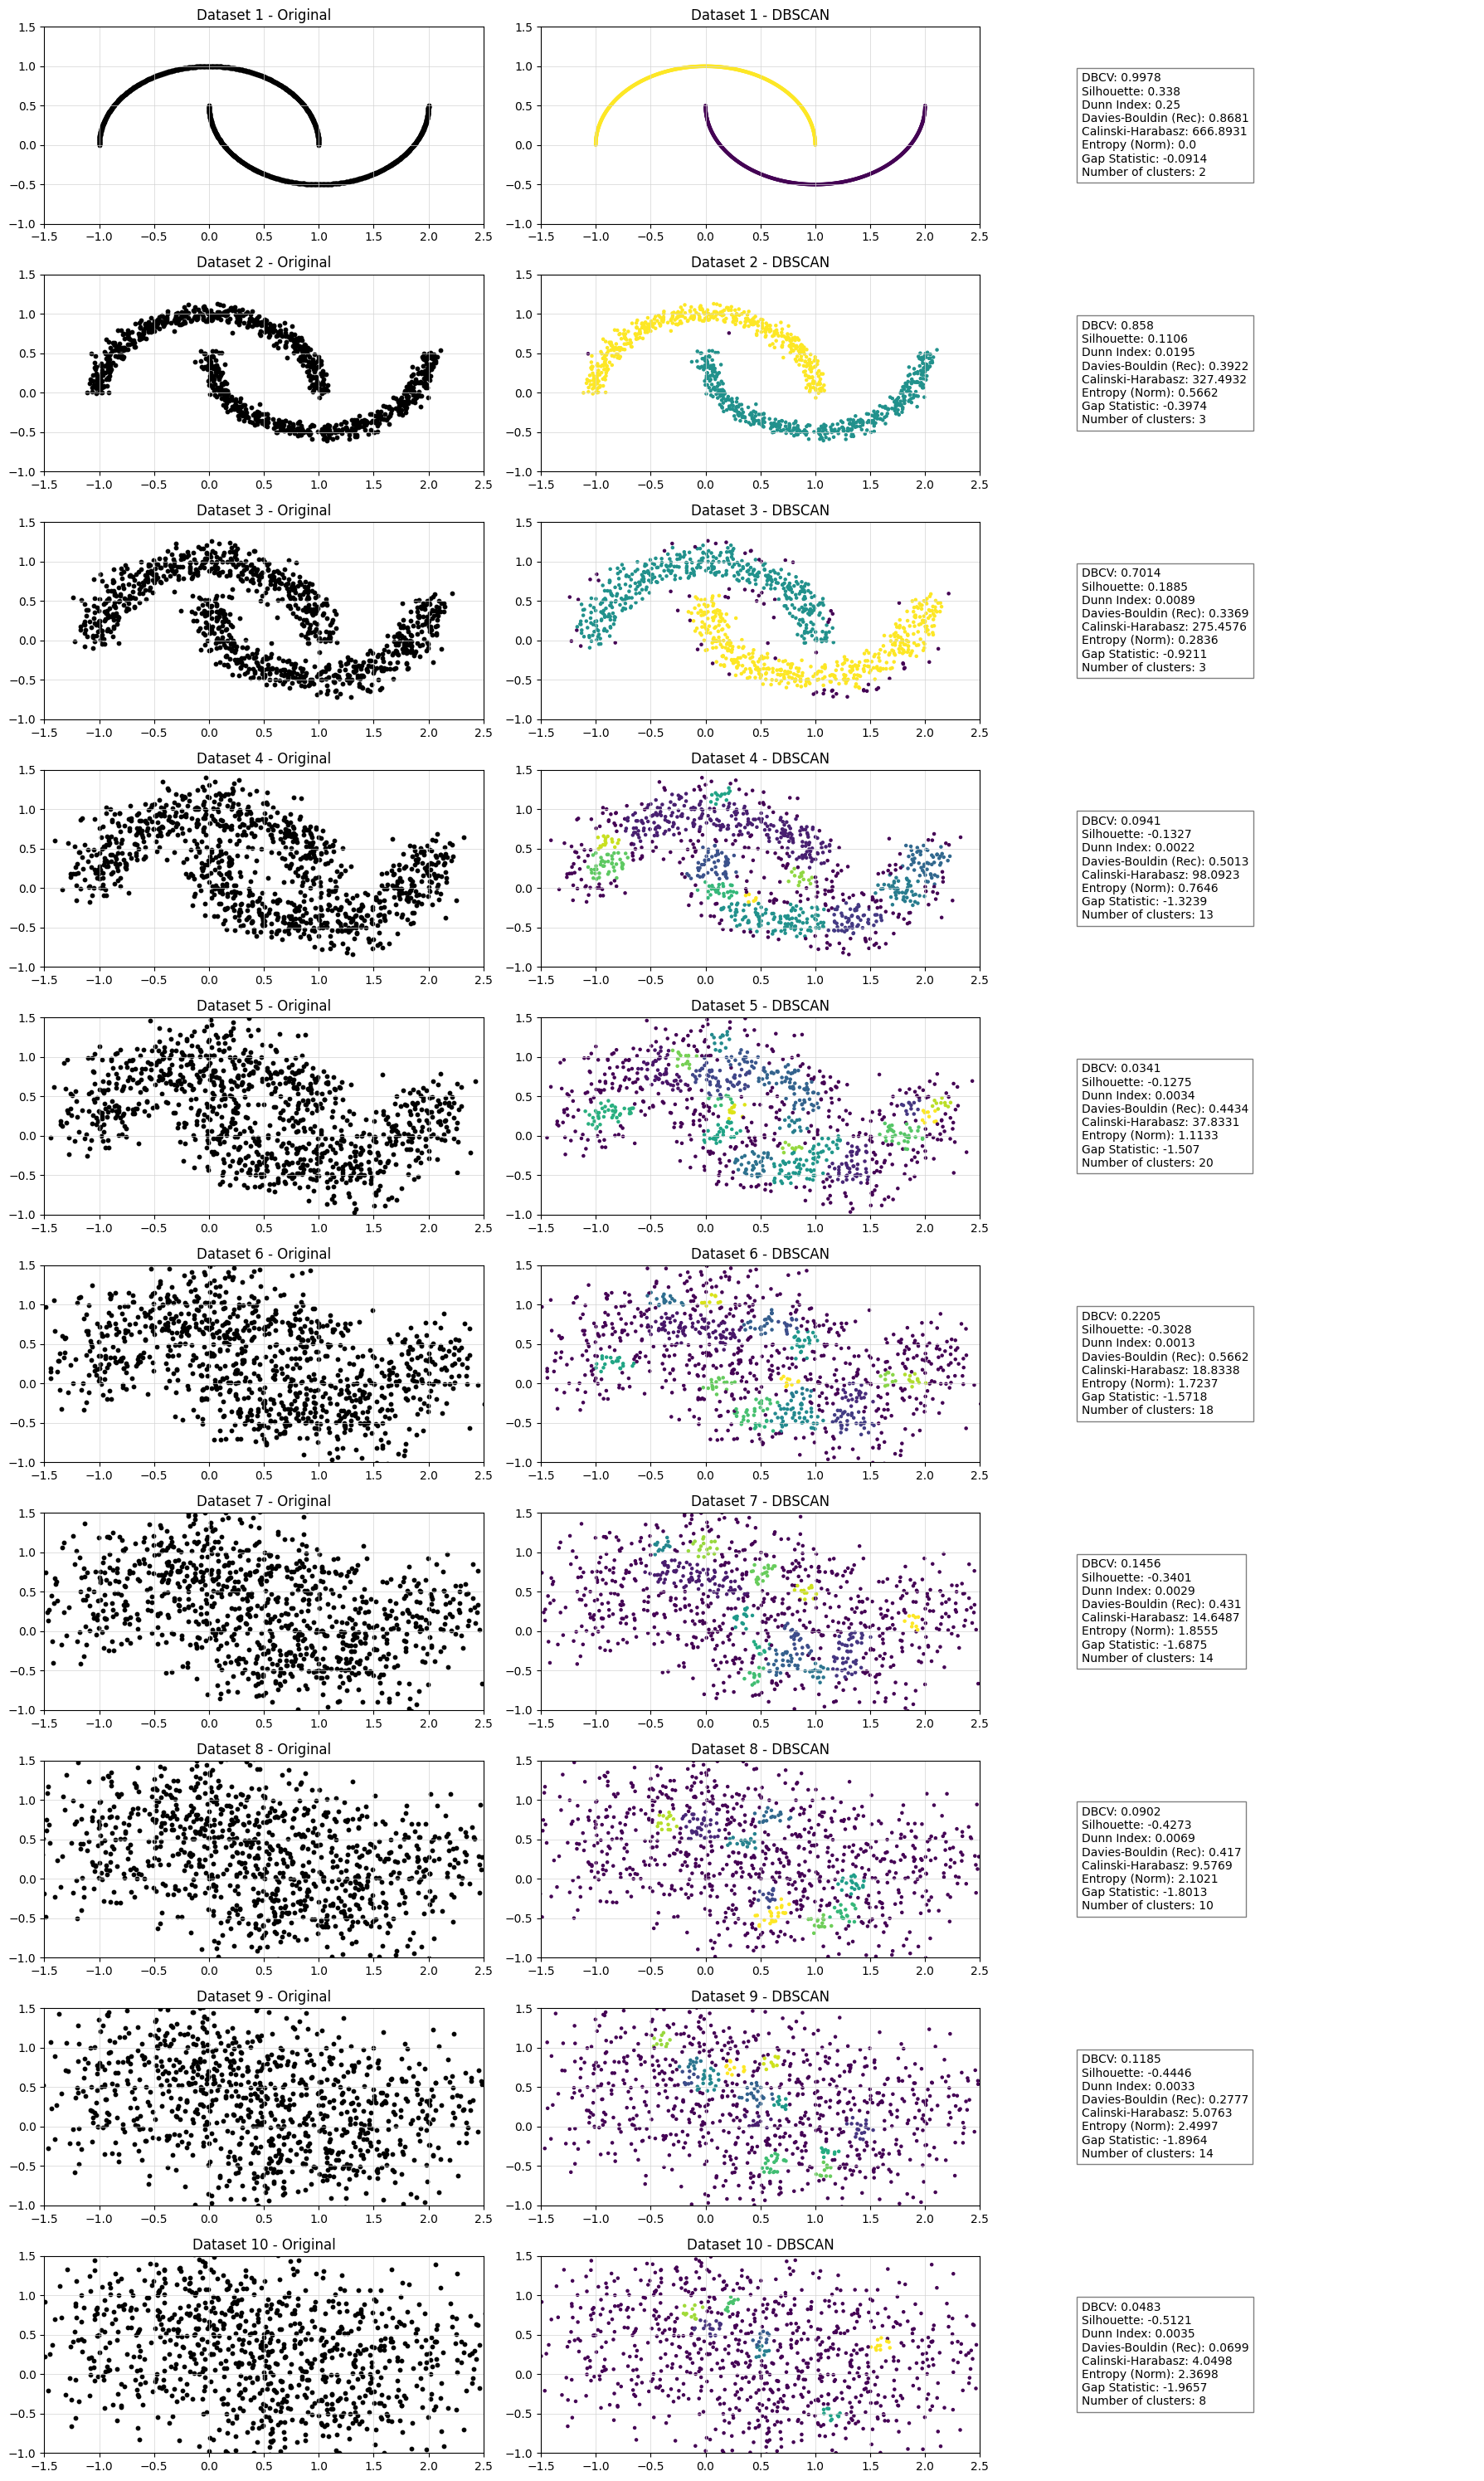

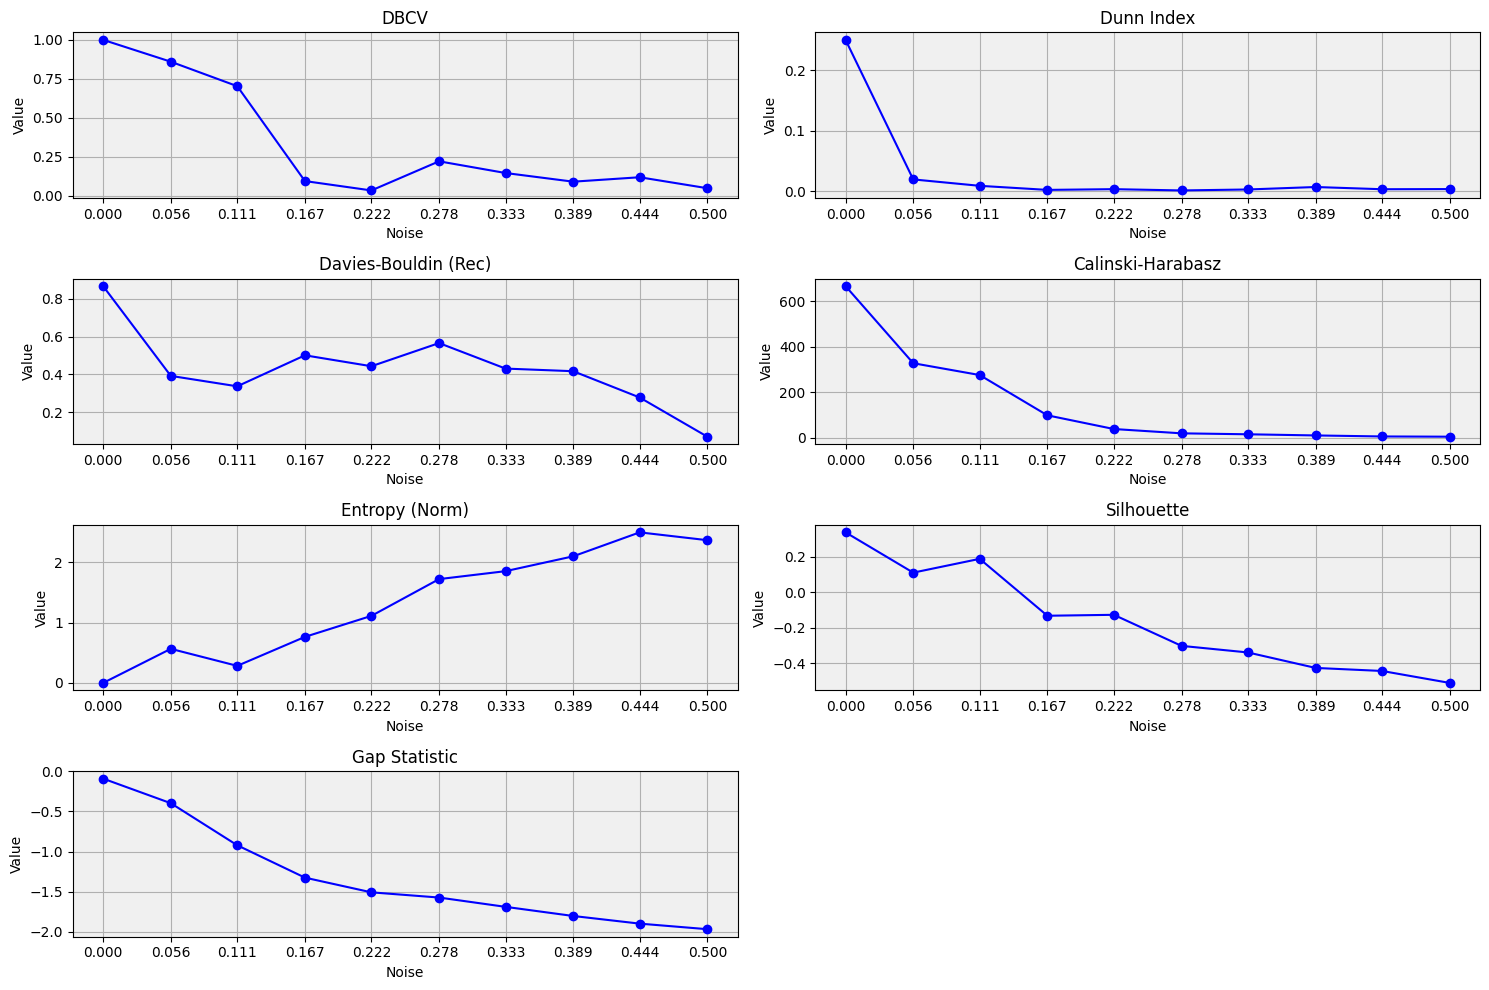

In [ ]:
datasets = generate_moon_datasets(30)
dbcv_total, dunn_total,davies_total, calinski_total,entropy_total, silhouette_total, gap_total = plot_datasets_with_clustering(datasets)
noise = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]

dbcv_total = list(zip(dbcv_total, noise))
dunn_total = list(zip(dunn_total, noise))
davies_total = list(zip(davies_total, noise))
calinski_total = list(zip(calinski_total, noise))
entropy_total = list(zip(entropy_total, noise))
silhouette_total = list(zip(silhouette_total, noise))
gap_total = list(zip(gap_total, noise))

data_list = [
    ("DBCV", dbcv_total),
    ("Dunn Index", dunn_total),
    ("Davies-Bouldin (Rec)", davies_total),
    ("Calinski-Harabasz", calinski_total),
    ("Entropy (Norm)", entropy_total),
    ("Silhouette", silhouette_total),
    ("Gap Statistic", gap_total)
]

plt.figure(figsize=(15, 10))

for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]

    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)

    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)

    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()

**Circle**

Eseguito su 1000 campioni con normal dbcv. Questo perchè fastdbcv da errori di duplicati in fase di calcolo.
CI vuole circa mezz'ora.

Se diminuimo il numero di campioni a 300 il tempo diminuisce notevolmente a 2 minuti.

con 1000 camponi min_samples = 20
con 300 campioni min_samples = 6

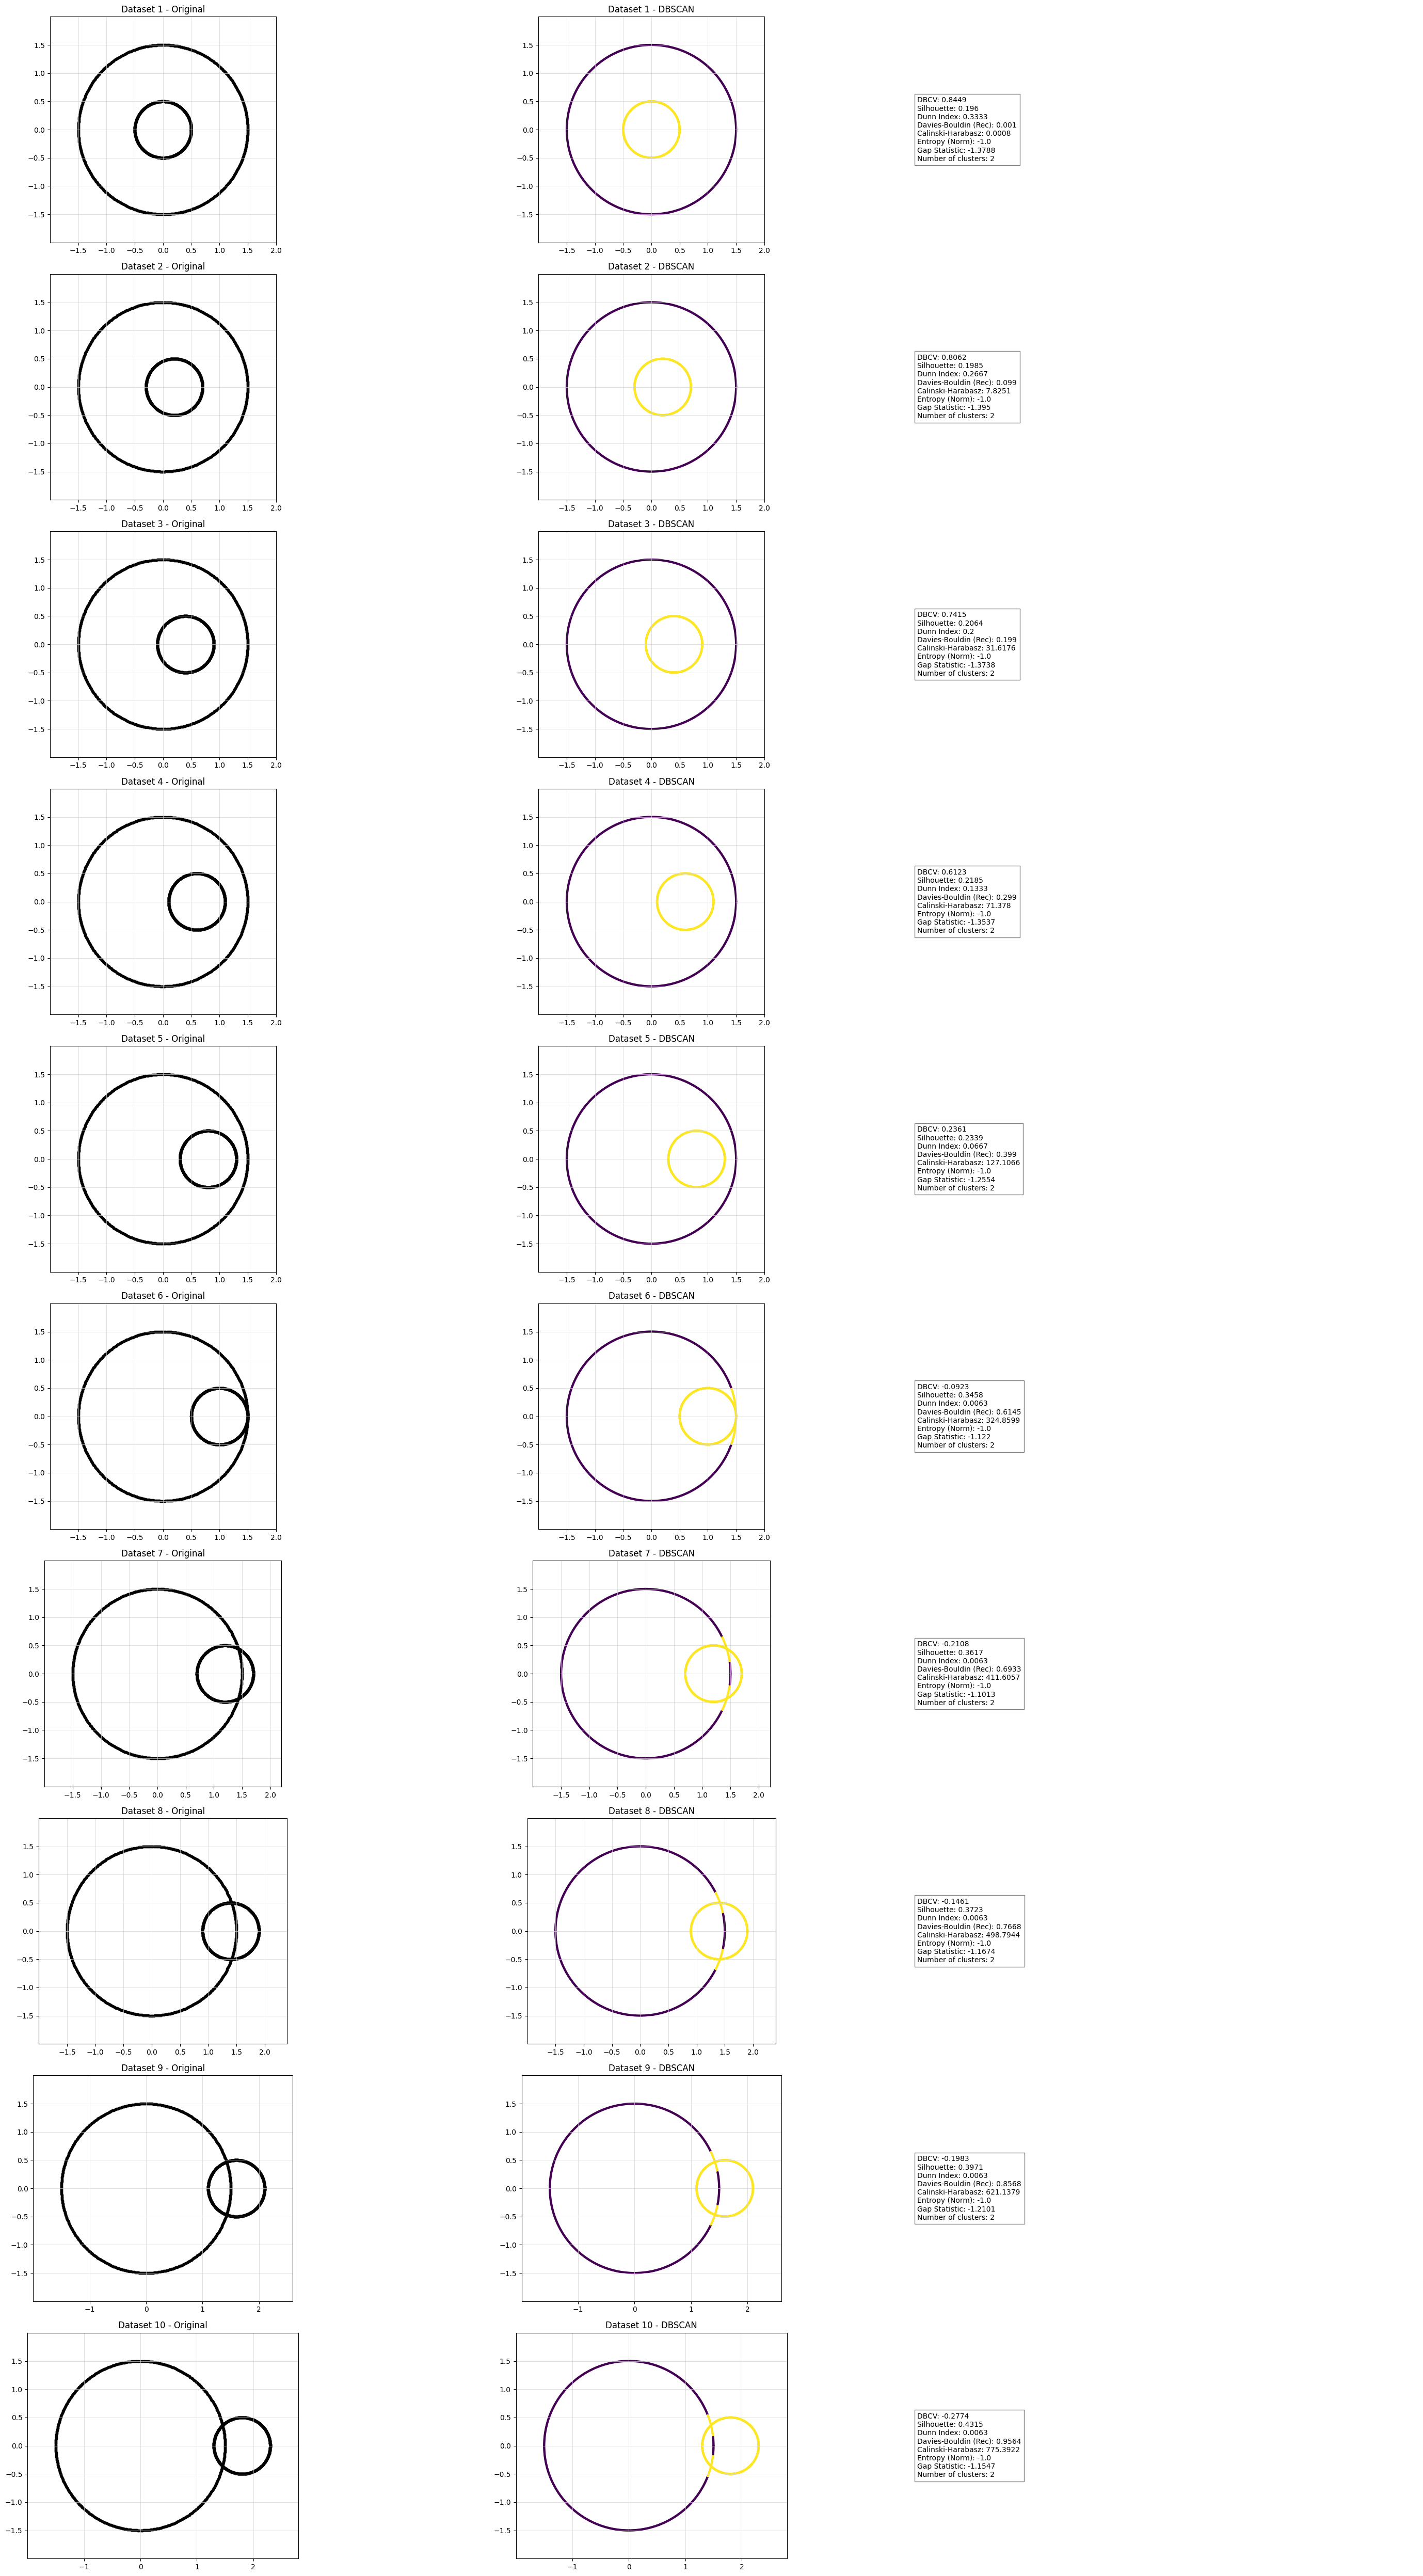

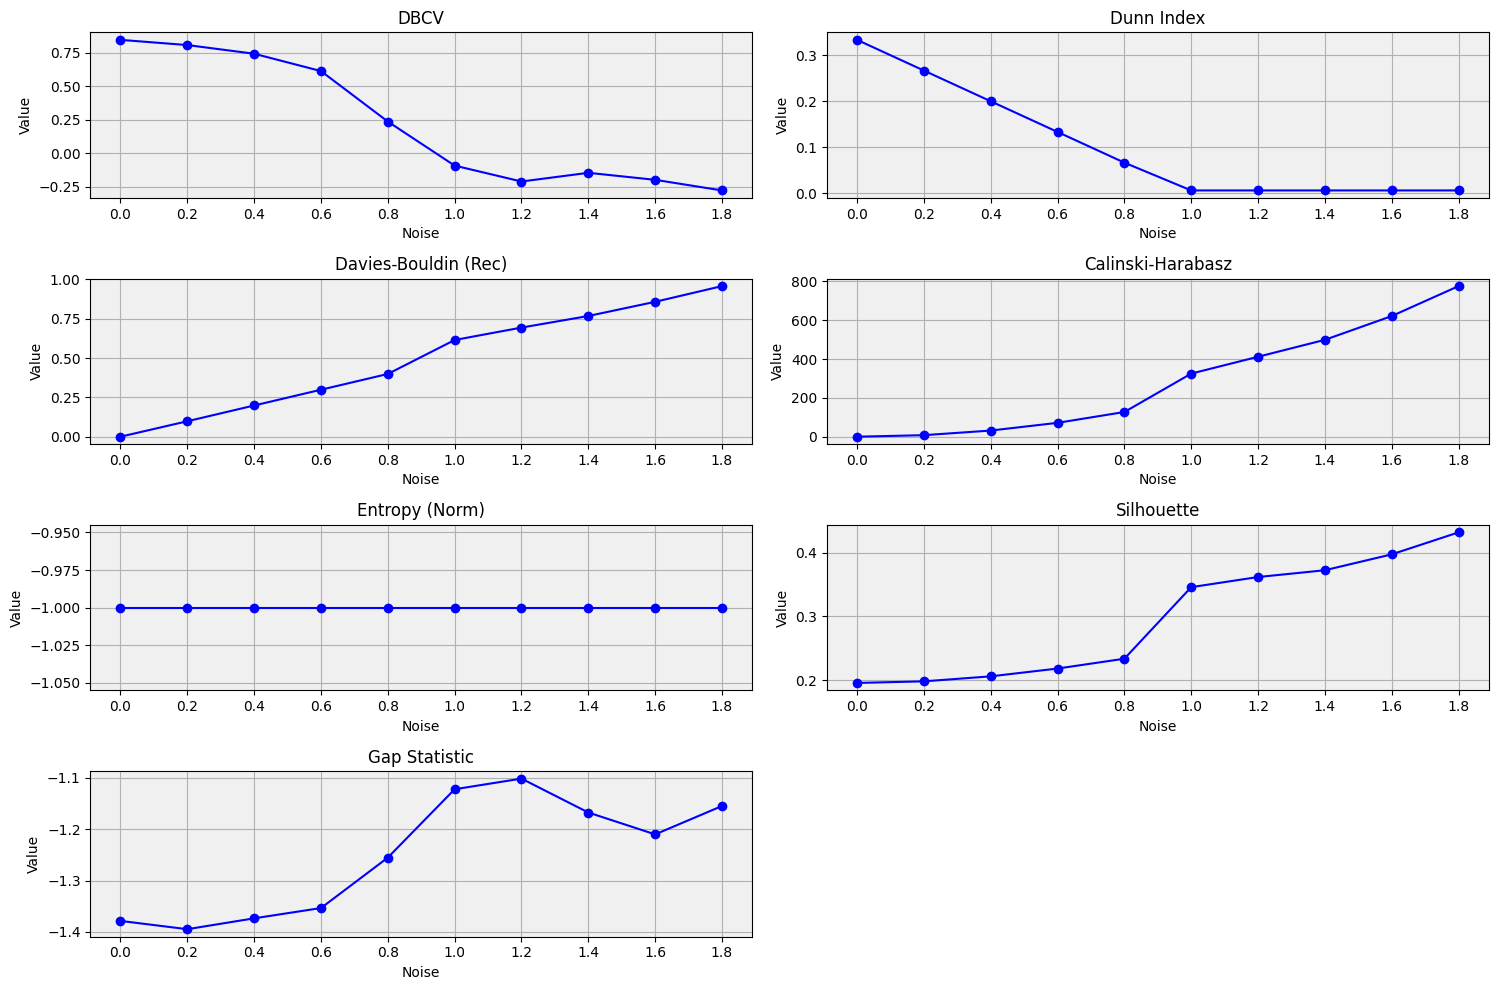

In [ ]:
n_datasets = 10
n_points_per_circle = 500
n_points_per_circle_inner = 500
inner_radius = 0.5
outer_radius = 1.5
initial_shift = (0, 0)
shift_increment = (0.2, 0)
datasets = generate_datasets_with_two_circles(n_datasets, n_points_per_circle, n_points_per_circle_inner, inner_radius, outer_radius, initial_shift, shift_increment)

dbcv_total, dunn_total,davies_total, calinski_total,entropy_total, silhouette_total, gap_total = plot_datasets_with_clustering_circle(datasets)

noise = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]

dbcv_total = list(zip(dbcv_total, noise))
dunn_total = list(zip(dunn_total, noise))
davies_total = list(zip(davies_total, noise))
calinski_total = list(zip(calinski_total, noise))
entropy_total = list(zip(entropy_total, noise))
silhouette_total = list(zip(silhouette_total, noise))
gap_total = list(zip(gap_total, noise))

data_list = [
    ("DBCV", dbcv_total),
    ("Dunn Index", dunn_total),
    ("Davies-Bouldin (Rec)", davies_total),
    ("Calinski-Harabasz", calinski_total),
    ("Entropy (Norm)", entropy_total),
    ("Silhouette", silhouette_total),
    ("Gap Statistic", gap_total)
]

plt.figure(figsize=(15, 10))

for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)

    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)

    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()


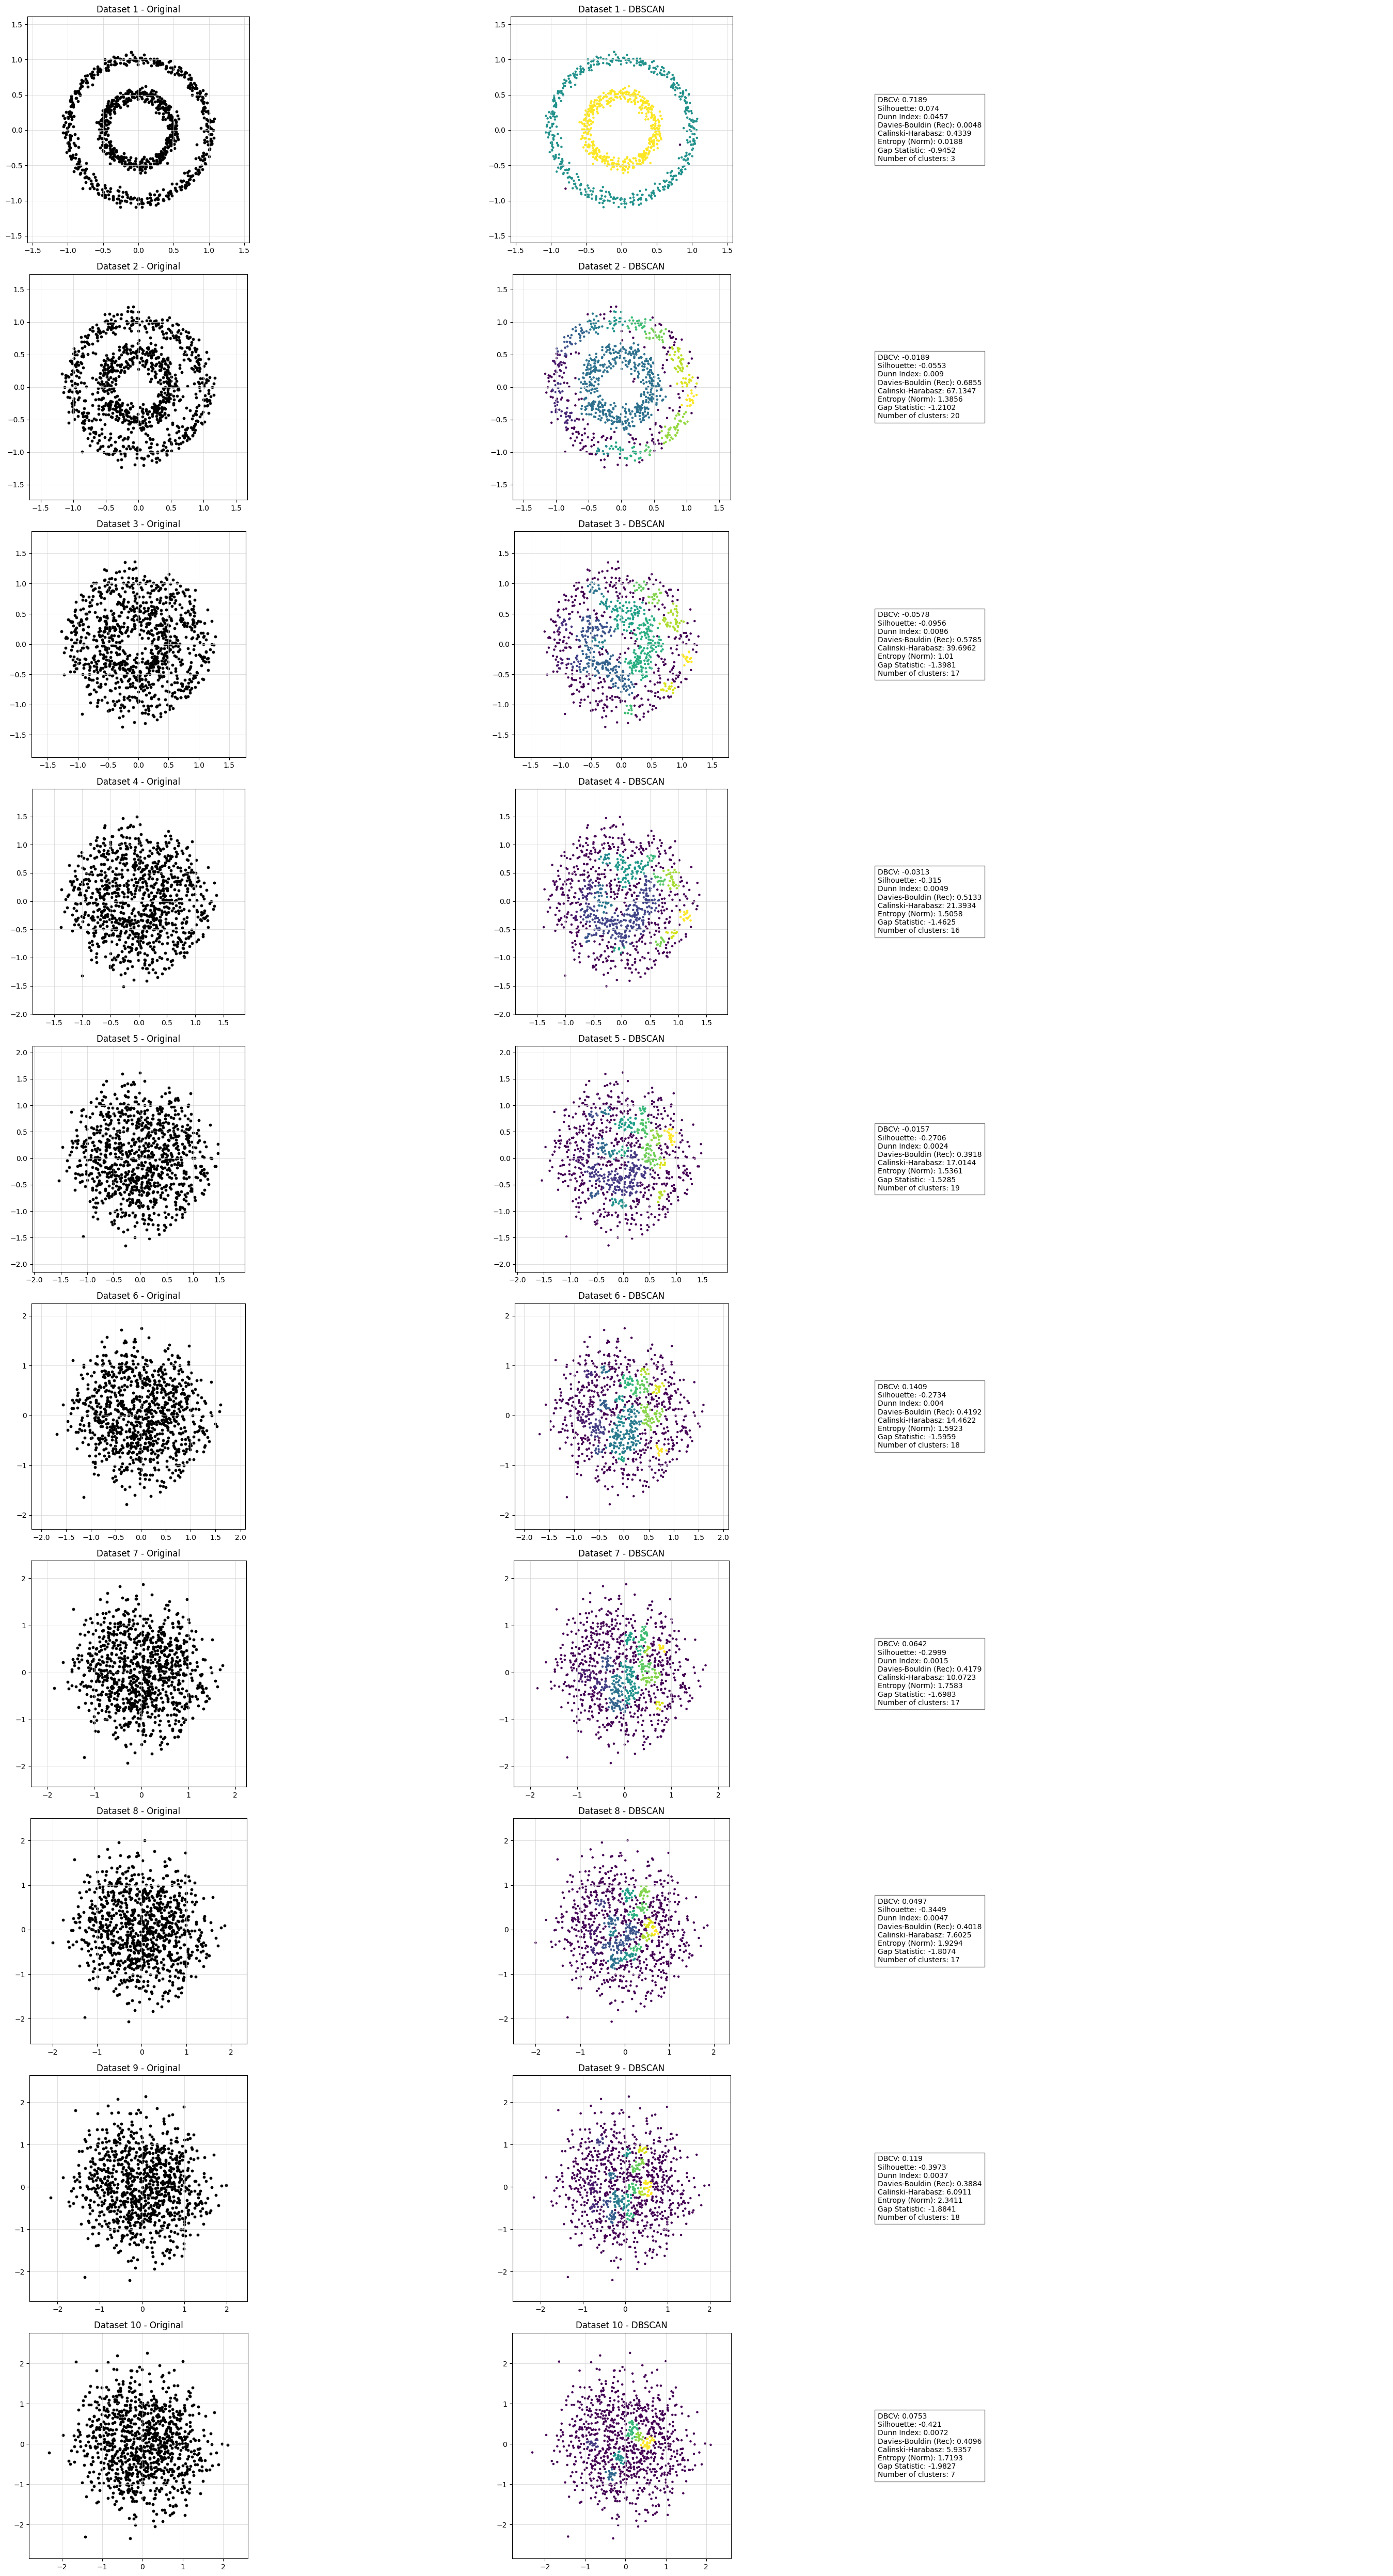

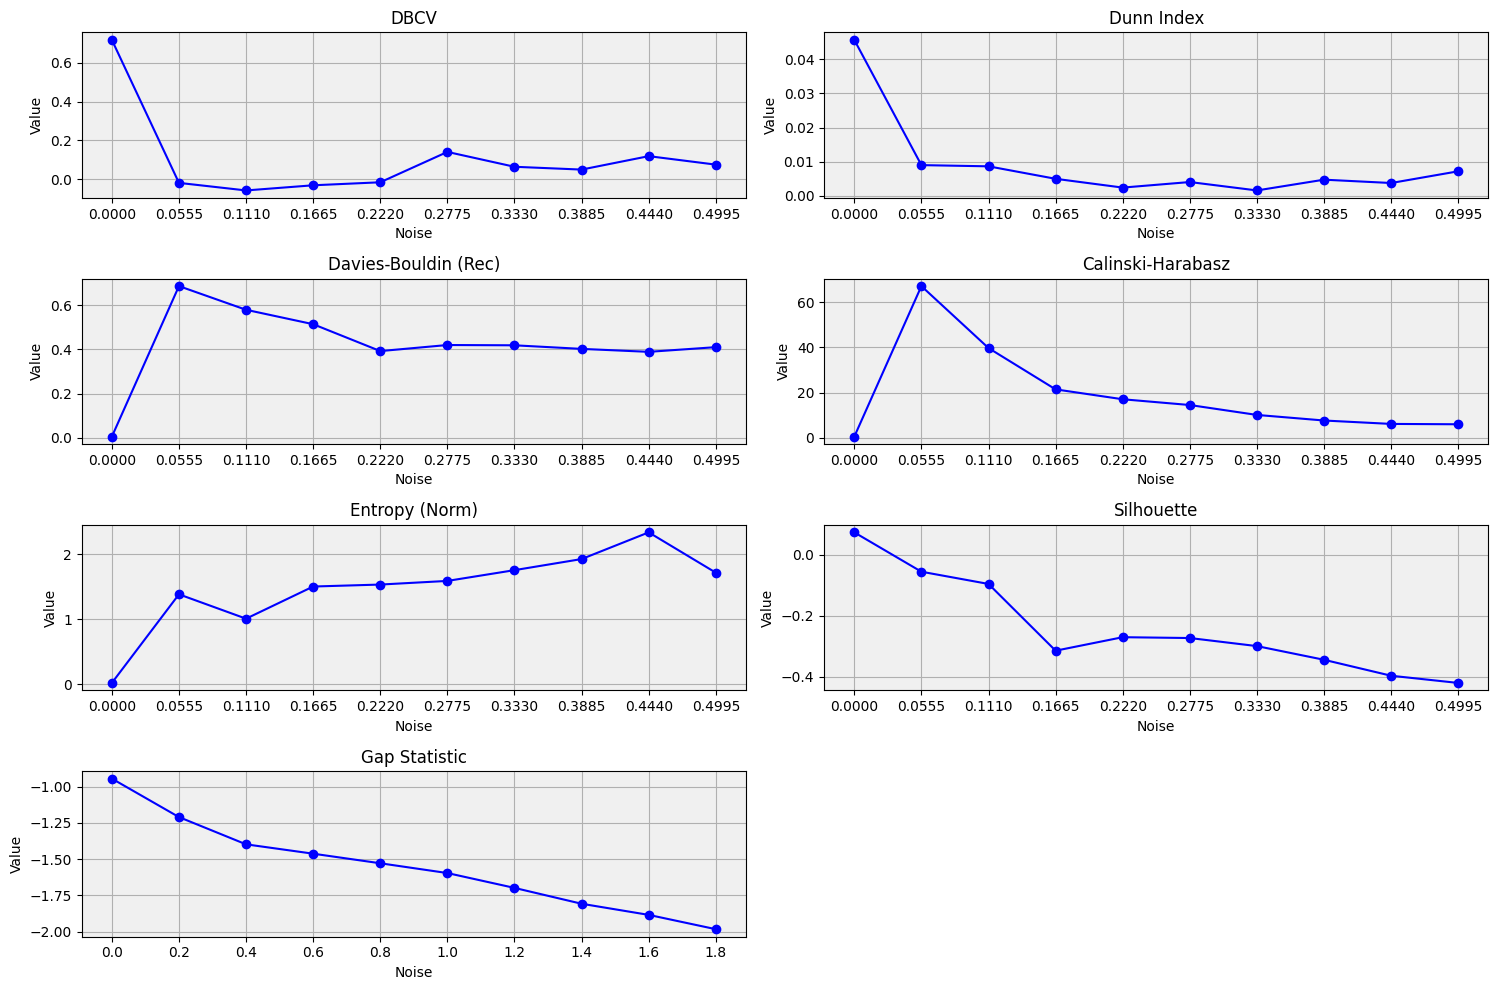

In [ ]:
n_datasets = 10
n_samples = 1000
noise_increment = 0.0555
seed = 4

#noise_levels = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]


datasets = generate_noisy_circles(n_datasets, n_samples, noise_increment, seed)


dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total = plot_datasets_with_clustering_noisy_circles(datasets)
noise_levels = [i * noise_increment for i in range(n_datasets)]

dbcv_total = list(zip(dbcv_total, noise_levels))
dunn_total = list(zip(dunn_total, noise_levels))
davies_total = list(zip(davies_total, noise_levels))
calinski_total = list(zip(calinski_total, noise_levels))
entropy_total = list(zip(entropy_total, noise_levels))
silhouette_total = list(zip(silhouette_total, noise_levels))
gap_total = list(zip(gap_total, noise))
data_list = [
    ("DBCV", dbcv_total),
    ("Dunn Index", dunn_total),
    ("Davies-Bouldin (Rec)", davies_total),
    ("Calinski-Harabasz", calinski_total),
    ("Entropy (Norm)", entropy_total),
    ("Silhouette", silhouette_total),
    ("Gap Statistic", gap_total)

]

plt.figure(figsize=(15, 10))

for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)

    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)

    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()


**Tulipan**

Inserire dataset con punti più raggruppati

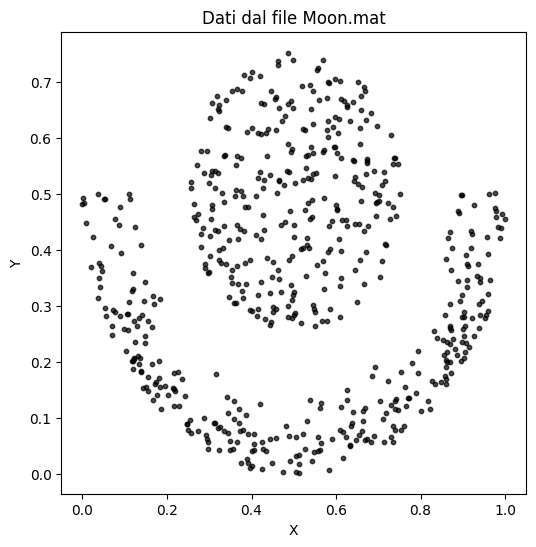

In [ ]:
# preso da https://github.com/adanjoga/cvik-toolbox/tree/master/datasets
#paper A survey of cluster validity indices for automatic data clustering using differential evolution

data = scipy.io.loadmat('/content/Moon.mat')

X = data['data'][:, 0]
Y = data['data'][:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(X, Y, color='black', alpha=0.7, s=10)
plt.title("Dati dal file Moon.mat")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


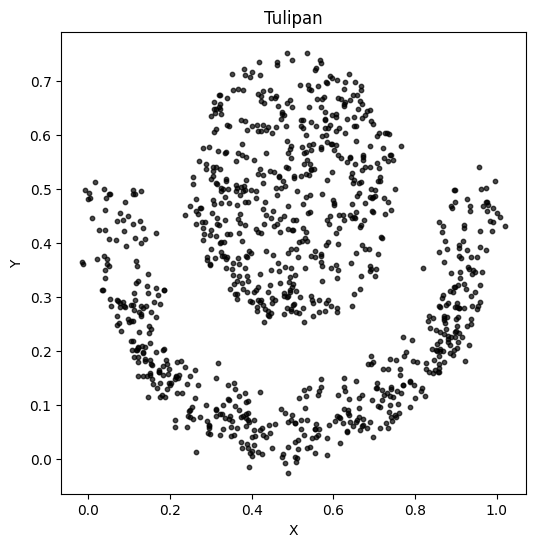

In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

data = scipy.io.loadmat('/content/Moon.mat')
X = data['data'][:, 0]
Y = data['data'][:, 1]


original_points = np.column_stack((X, Y))

# Generate 400 new points by sampling around the existing data
# Adding some random noise to keep them close to the existing distribution
num_new_points = 400
new_points = original_points[np.random.choice(original_points.shape[0], num_new_points)] + np.random.normal(0, 0.02, (num_new_points, 2))
augmented_data = np.vstack((original_points, new_points))
X_augmented = augmented_data[:, 0]
Y_augmented = augmented_data[:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(X_augmented, Y_augmented, color='black', alpha=0.7, s=10)
plt.title("Tulipan")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

AL dataset originale sono dati aggiutni 400 punti (essendo 600 quelli attuali). I 600 attualirimangono fissi, viene aggiunto del rumore ai 400 inseriti , normalizzando il loro valore tra 0 e 1 in modo da essere inseritiall'interno del tulipano e non all'esterno

/usr/local/lib/python3.10/dist-packages/DBCV/DBCV.py:217: RuntimeWarning: invalid value encountered in scalar divide
  cluster_validity = numerator / denominator
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (12) found sma

[(nan, -1, -1, -1, -1, -0.0, 70.5470722283088, array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]))]
#######
(nan, -1, -1, -1, -1, -0.0, 70.5470722283088, array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]))
[(nan, -1, -1, -1, -1, -0.0, 1.1020002315034652, array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]))]
#######
(nan, -1, -1, -1, -1, -0.0, 1.1020002315034652, array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

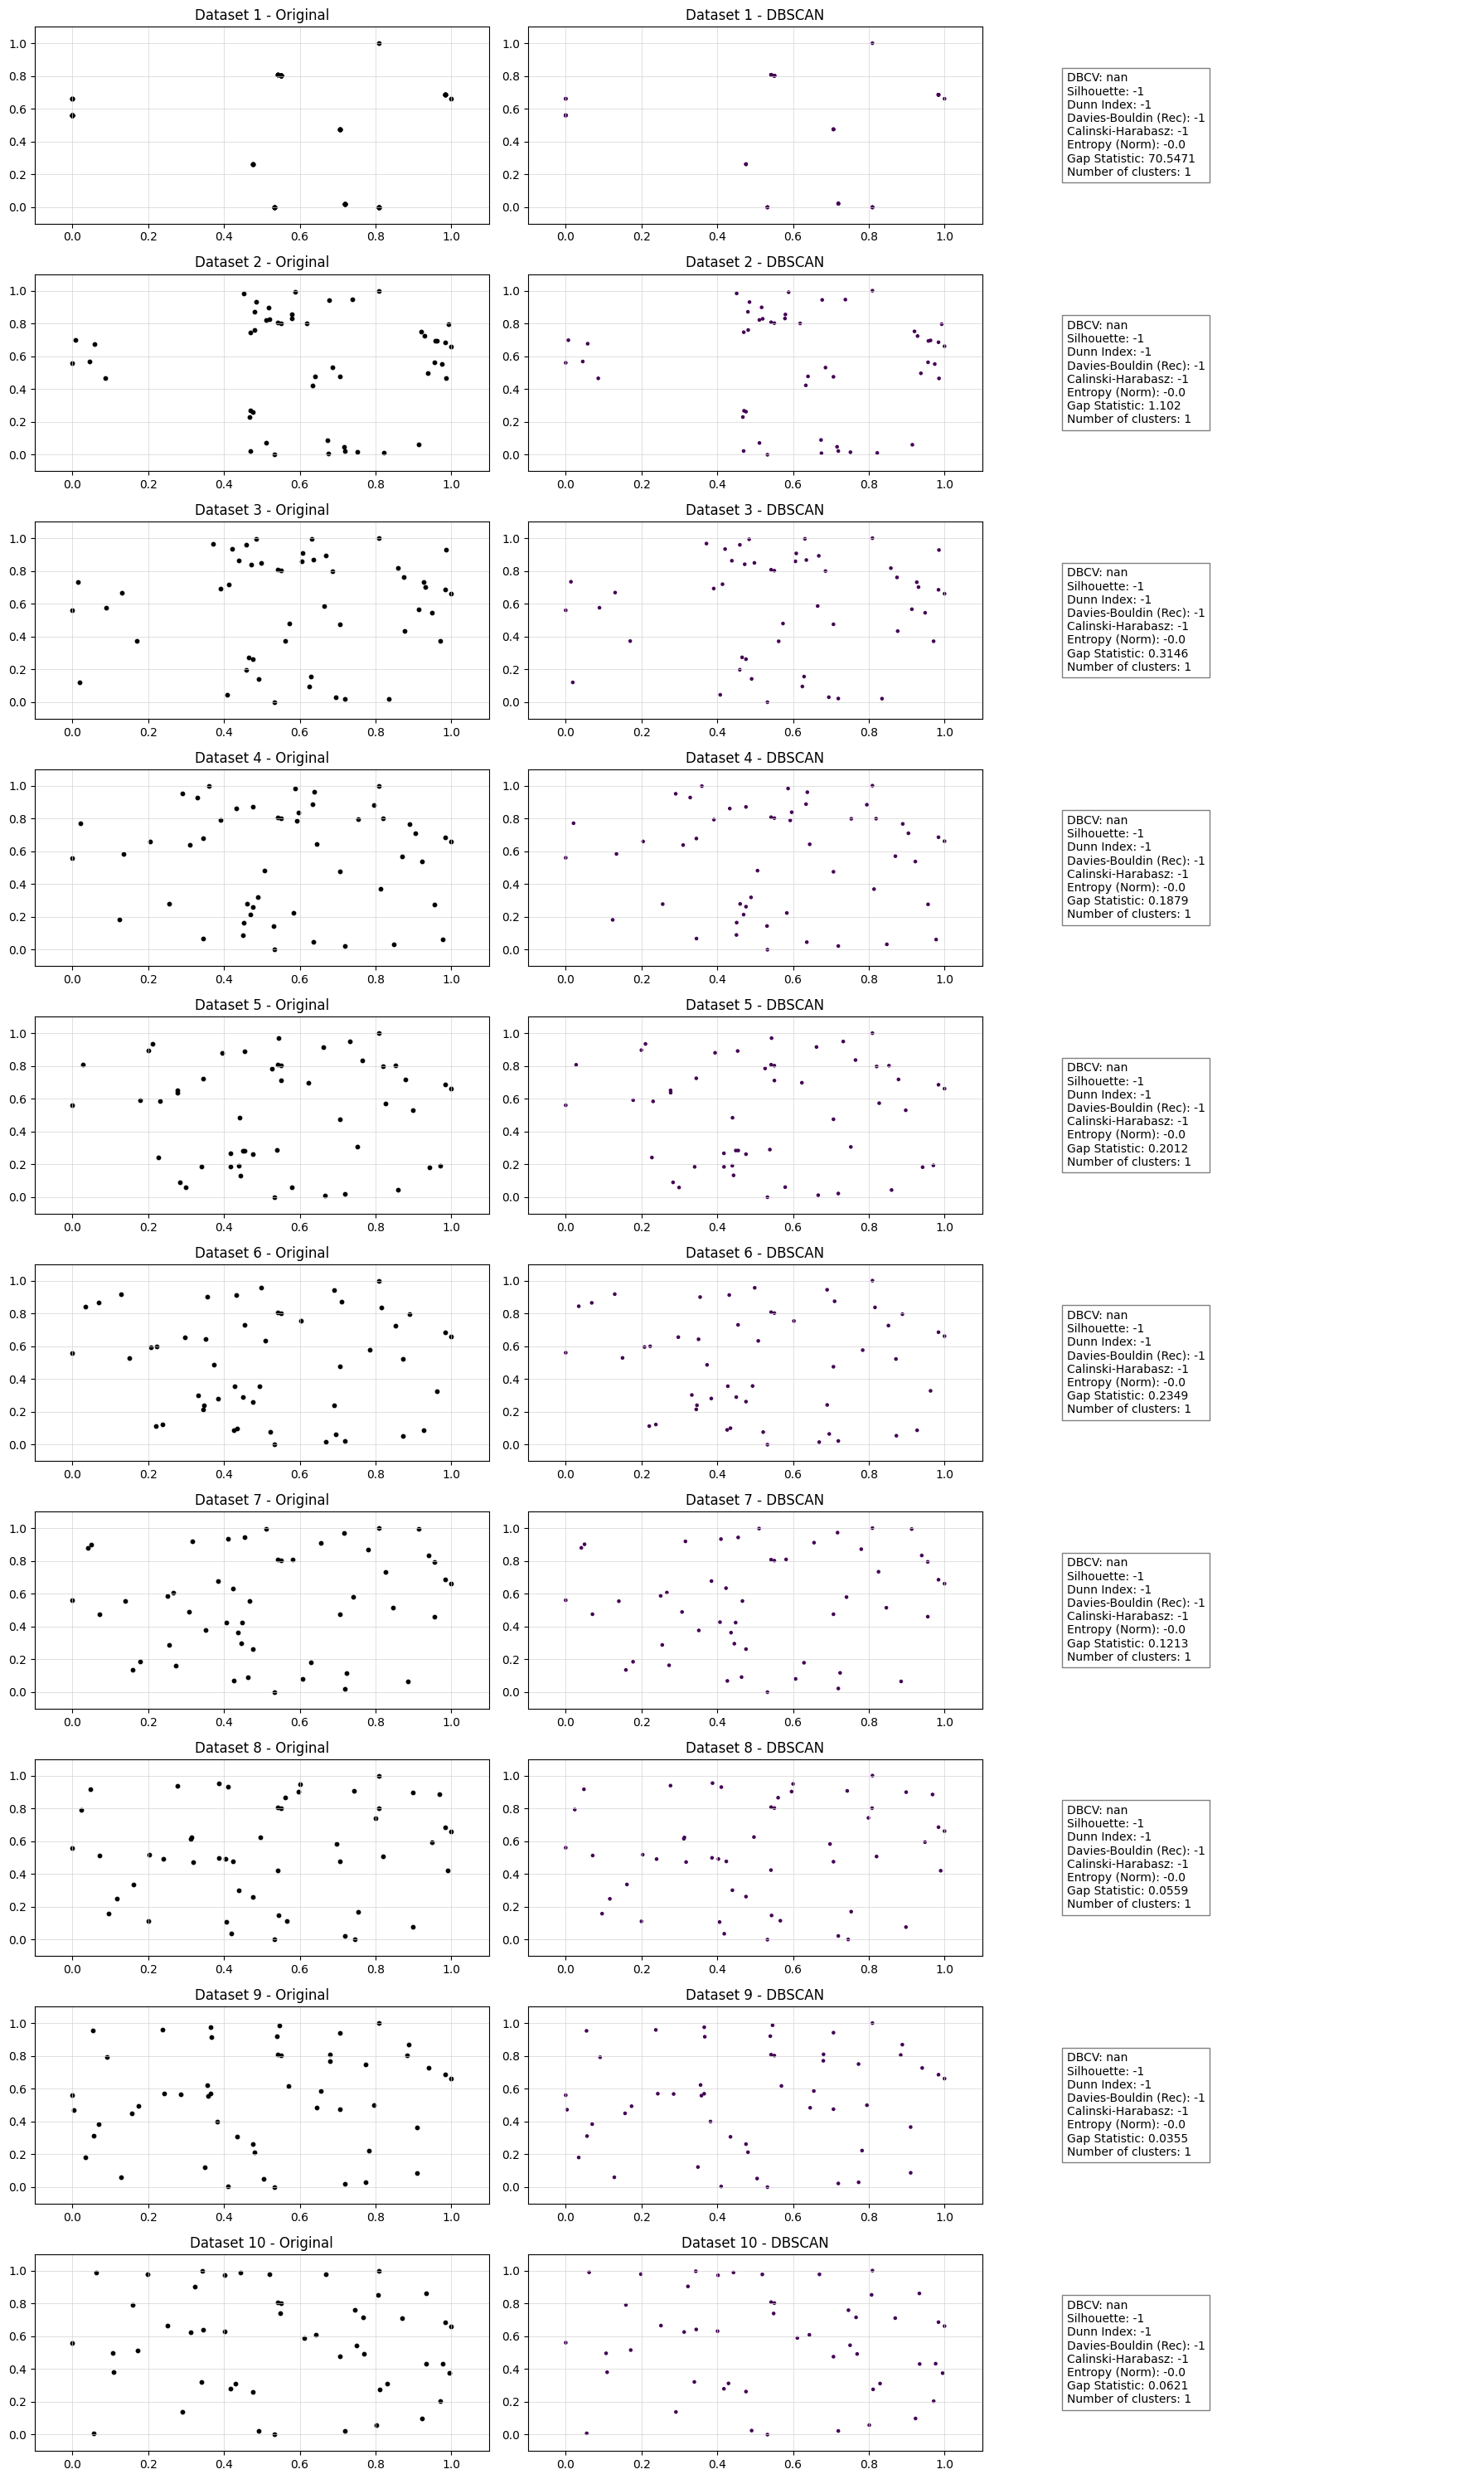

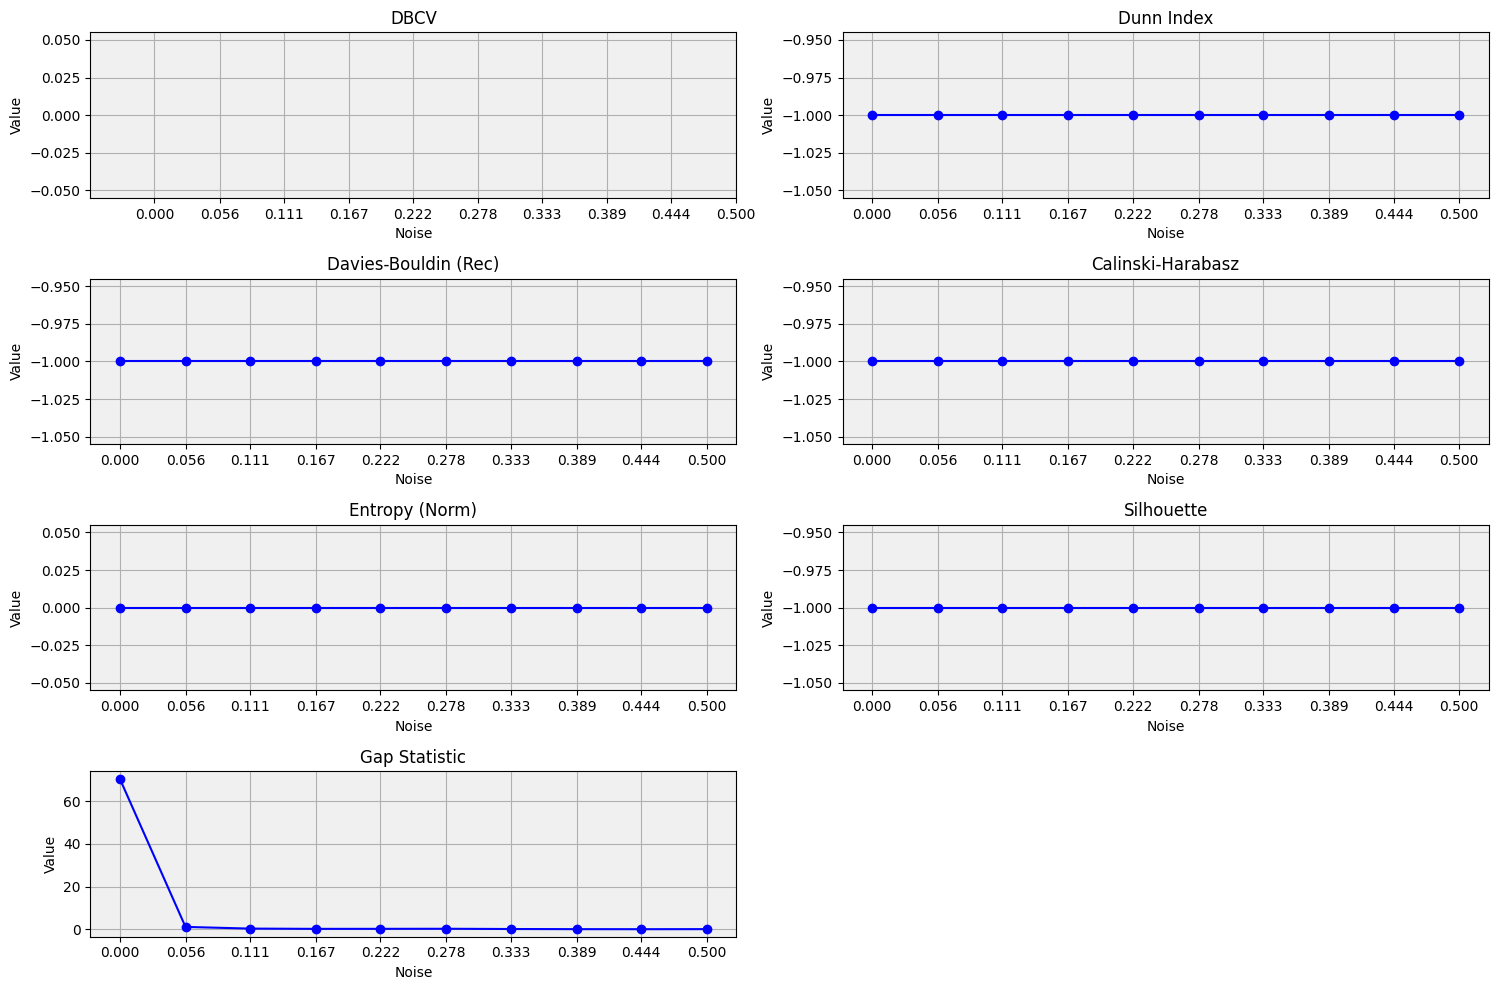

In [ ]:
data = scipy.io.loadmat('/content/Moon.mat')
X = data['data'][:, 0]
Y = data['data'][:, 1]
original_points = np.column_stack((X, Y))

min_vals = original_points.min(axis=0)
max_vals = original_points.max(axis=0)
normalized_points = (original_points - min_vals) / (max_vals - min_vals)

datasets = generate_augmented_datasets(30)
results = analyze_datasets_tulipan(datasets)
dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total = plot_datasets_with_clustering_tulipan(datasets, results)

noise_levels = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]

dbcv_total = list(zip(dbcv_total, noise))
dunn_total = list(zip(dunn_total, noise))
davies_total = list(zip(davies_total, noise))
calinski_total = list(zip(calinski_total, noise))
entropy_total = list(zip(entropy_total, noise))
silhouette_total = list(zip(silhouette_total, noise))
gap_total = list(zip(gap_total, noise))

data_list = [
    ("DBCV", dbcv_total),
    ("Dunn Index", dunn_total),
    ("Davies-Bouldin (Rec)", davies_total),
    ("Calinski-Harabasz", calinski_total),
    ("Entropy (Norm)", entropy_total),
    ("Silhouette", silhouette_total),
    ("Gap Statistic", gap_total)
]

plt.figure(figsize=(15, 10))
for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)
    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)
    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()


#**EHRs**

In [105]:
neuroblastoma=pd.read_csv("/content/10_7717_peerj_5665_dataYM2018_neuroblastoma.csv")
diabetes=pd.read_csv("/content/journal.pone.0216416_Takashi2019_diabetes_type1_dataset_preprocessed.csv")
sepsis=pd.read_csv("/content/journal.pone.0148699_S1_Text_Sepsis_SIRS_EDITED.csv")
heart_failure=pd.read_csv("/content/journal.pone.0158570_S2File_depression_heart_failure_v2.csv")
cardiac_arrest=pd.read_csv("/content/journal.pone.0175818_S1Dataset_Spain_cardiac_arrest_EDITED..csv")
df_metrics=pd.DataFrame()

#**Neuroblastoma**

In [106]:
neuroblastoma = neuroblastoma.dropna(thresh=neuroblastoma.shape[1] - 2)
numerical_features = neuroblastoma.columns
scaler_minmax = MinMaxScaler()
neuroblastoma_scaled = neuroblastoma.copy()
neuroblastoma_scaled[numerical_features] = scaler_minmax.fit_transform(neuroblastoma[numerical_features])
neuroblastoma_scaled.reset_index(drop=True, inplace=True)
neuroblastoma_scaled.drop_duplicates(inplace=True)
neuroblastoma_scaled

age  sex  site  stage  risk  time_months  \
0    1.0  0.0   0.0    1.0   1.0     0.060606   
1    1.0  0.0   0.0    1.0   1.0     0.181818   
2    0.5  0.0   0.0    1.0   1.0     0.242424   
3    0.5  0.0   0.0    1.0   1.0     0.070707   
4    0.5  0.0   0.0    1.0   1.0     0.464646   
..   ...  ...   ...    ...   ...          ...   
164  0.0  0.0   0.0    0.0   0.0     0.353535   
165  0.5  0.0   0.0    0.0   0.0     0.171717   
166  0.5  1.0   0.5    0.0   0.0     0.373737   
167  0.5  1.0   0.5    0.0   0.0     0.363636   
168  0.0  0.0   0.0    0.0   0.0     0.313131   

     autologous_stem_cell_transplantation  radiation  \
0                                     0.0        0.0   
1                                     0.0        1.0   
2                                     0.0        1.0   
3                                     0.0        0.0   
4                                     1.0        1.0   
..                                    ...        ...   
164                                   0.0        0.0   
165                                   0.0        0.0   
166                                   0.0        0.0   
167                                   0.0        0.0   
168                                   0.0        0.0   

     degree_of_differentiation  UH_or_FH  MYCN_status   surgical_methods  \
0                          0.0       0.0           1.0               1.0   
1                          0.0       0.0           1.0               1.0   
2                          0.5       0.0           1.0               0.0   
3                          0.5       0.0           1.0               1.0   
4                          0.5       0.0           1.0               0.0   
..                         ...       ...           ...               ...   
164                        0.0       0.0           1.0               0.0   
165                        0.5       1.0           1.0               1.0   
166                        1.0       1.0           1.0               0.0   
167                        0.5       1.0           1.0               0.0   
168                        0.0       0.0           1.0               0.0   

     outcome  
0        0.0  
1        1.0  
2        1.0  
3        0.0  
4        1.0  
..       ...  
164      0.0  
165      1.0  
166      0.0  
167      0.0  
168      0.0  

[168 rows x 13 columns]

**HSBSCAN**

In [107]:
min_size, epsilon= best_params_hdbscan(neuroblastoma_scaled)
dbscan_pca= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
clusters_pca = dbscan_pca.fit_predict(neuroblastoma_scaled)
dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels)
neuroblastoma_scaled['HDBSCAN_pred'] = clusters_pca
methods = 'HDBSCAN'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Shannon Entropy Norm': shannon_entropy_norm,
    'Optimal Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
df_metrics = pd.concat([df_metrics, metrics_df], ignore_index=True)


min_cluster_size: 15, cluster_selection_epsilon: 0.01


**DBSCAN**

In [108]:
min_sample, eps = best_params_dbscan(neuroblastoma_scaled)
dbscan = DBSCAN(min_samples=min_sample, eps=eps)
labels = dbscan.fit_predict(neuroblastoma_scaled)
dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels)
neuroblastoma_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Shannon Entropy Norm': shannon_entropy_norm,
    'Optimal Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
df_metrics = pd.concat([df_metrics, metrics_df], ignore_index=True)

min_cluster_size: 3, cluster_selection_epsilon: 0.5


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0  HDBSCAN        0.27       -0.07           0                 0.77   
1   DBSCAN        0.26       -0.06           0                 0.75   

   Calinski-Harabasz  Shannon Entropy Norm  Optimal Gap Statistic  
0               3.63                  1.85                  -0.02  
1               3.42                  1.85                   0.07

**Mean_Shift**

In [109]:
band = best_params_mean_shift(neuroblastoma_scaled)
mean_shift = MeanShift(bandwidth=band)
clusters_mean_shift = mean_shift.fit_predict(neuroblastoma_scaled)
dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels)
neuroblastoma_scaled['Mean_shift_pred'] = clusters_mean_shift

methods = 'Mean_shift'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Shannon Entropy Norm': shannon_entropy_norm,
    'Optimal Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
df_metrics = pd.concat([df_metrics, metrics_df], ignore_index=True)
df_metrics

Errore calcolando DBCV per banda 0.292: zero-size array to reduction operation maximum which has no identity
Errore calcolando DBCV per banda 0.877: zero-size array to reduction operation maximum which has no identity
Errore calcolando DBCV per banda 1.461: zero-size array to reduction operation maximum which has no identity
Best bandwidth: 4.967


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0     HDBSCAN        0.27       -0.07           0                 0.77   
1      DBSCAN        0.26       -0.06           0                 0.75   
2  Mean_shift        0.30        0.26           0                 2.36   

   Calinski-Harabasz  Shannon Entropy Norm  Optimal Gap Statistic  
0               3.63                  1.85                  -0.02  
1               3.42                  1.85                   0.07  
2             106.53                  1.85                  -0.16

In [116]:
# Valori fino a 3.5 https://it.wikipedia.org/wiki/Funzione_degli_errori
from scipy.special import erf
val1=(erf(3.63))
val2=(erf(3.42))
val3=(erf(106.53))
print(val1,val2,val3)

val4= (erf(3.63) + 1) / 2
val5= (erf(3.42) + 1) / 2
val6= (erf(106.53) + 1) / 2
print(val4,val5,val6)

0.999999715740906 0.9999986792805643 1.0
0.999999857870453 0.9999993396402822 1.0


**Cluster Analysis**

In [111]:
cluster_similarity = similar_cluster(neuroblastoma_scaled)
cluster_similarity

[0 1]
[-1  0  1  2  3  6  4  5  7  8  9 10 12 11 13]
[ 0 -1  1]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
0            0      -1        0    42.857143
1            0      -1       -1    19.642857
2            0      -1        1     6.547619
57           1       3        0     3.571429
60           1       6        0     2.976190
..         ...     ...      ...          ...
33           0      10        0     0.000000
32           0       9        1     0.000000
31           0       9       -1     0.000000
30           0       9        0     0.000000
45           1      -1        0     0.000000

[90 rows x 4 columns]

In [112]:
neuroblastoma_scaled["DBSCAN_pred"] = neuroblastoma_scaled["DBSCAN_pred"].astype(object)
neuroblastoma_scaled["HDBSCAN_pred"] = neuroblastoma_scaled["HDBSCAN_pred"].astype(object)
neuroblastoma_scaled["Mean_shift_pred"] = neuroblastoma_scaled["Mean_shift_pred"].astype(object)

neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'A'
neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_pred"] == 0, "HDBSCAN_pred"] = 'A'
neuroblastoma_scaled.loc[neuroblastoma_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'A'

neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_pred"] == 13, "DBSCAN_pred"] = 'B'
neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_pred"] == 1, "HDBSCAN_pred"] = 'B'
neuroblastoma_scaled.loc[neuroblastoma_scaled["Mean_shift_pred"] == 7, "Mean_shift_pred"] = 'B'

neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_pred"] == 1, "DBSCAN_pred"] = 'C'
neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_pred"] == -1, "HDBSCAN_pred"] = 'C'
neuroblastoma_scaled.loc[neuroblastoma_scaled["Mean_shift_pred"] == 6, "Mean_shift_pred"] = 'C'

neuroblastoma_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    neuroblastoma_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1, 'C': 2})
    .astype(int)
)

same_value_count = (neuroblastoma_scaled["HDBSCAN_pred"] == neuroblastoma_scaled["DBSCAN_pred"]) & \
                   (neuroblastoma_scaled["DBSCAN_pred"] == neuroblastoma_scaled["Mean_shift_pred"])

total_same_value = same_value_count.sum()
total_rows = len(neuroblastoma_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(neuroblastoma_scaled)
df_metrics['Correct prediction'] = percentage_same_value
df_metrics['ARI'] = ari
df_metrics

Totale delle righe con lo stesso valore: 81
Percentuale rispetto al totale: 48.21 %


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0     HDBSCAN        0.27       -0.07           0                 0.77   
1      DBSCAN        0.26       -0.06           0                 0.75   
2  Mean_shift        0.30        0.26           0                 2.36   

   Calinski-Harabasz  Shannon Entropy Norm  Optimal Gap Statistic  \
0               3.63                  1.85                  -0.02   
1               3.42                  1.85                   0.07   
2             106.53                  1.85                  -0.16   

   Correct prediction       ARI  
0               0.482  0.321196  
1               0.482  0.321196  
2               0.482  0.321196

In [113]:
df_metrics

Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0     HDBSCAN        0.27       -0.07           0                 0.77   
1      DBSCAN        0.26       -0.06           0                 0.75   
2  Mean_shift        0.30        0.26           0                 2.36   

   Calinski-Harabasz  Shannon Entropy Norm  Optimal Gap Statistic  \
0               3.63                  1.85                  -0.02   
1               3.42                  1.85                   0.07   
2             106.53                  1.85                  -0.16   

   Correct prediction       ARI  
0               0.482  0.321196  
1               0.482  0.321196  
2               0.482  0.321196

<Figure size 1000x800 with 0 Axes>

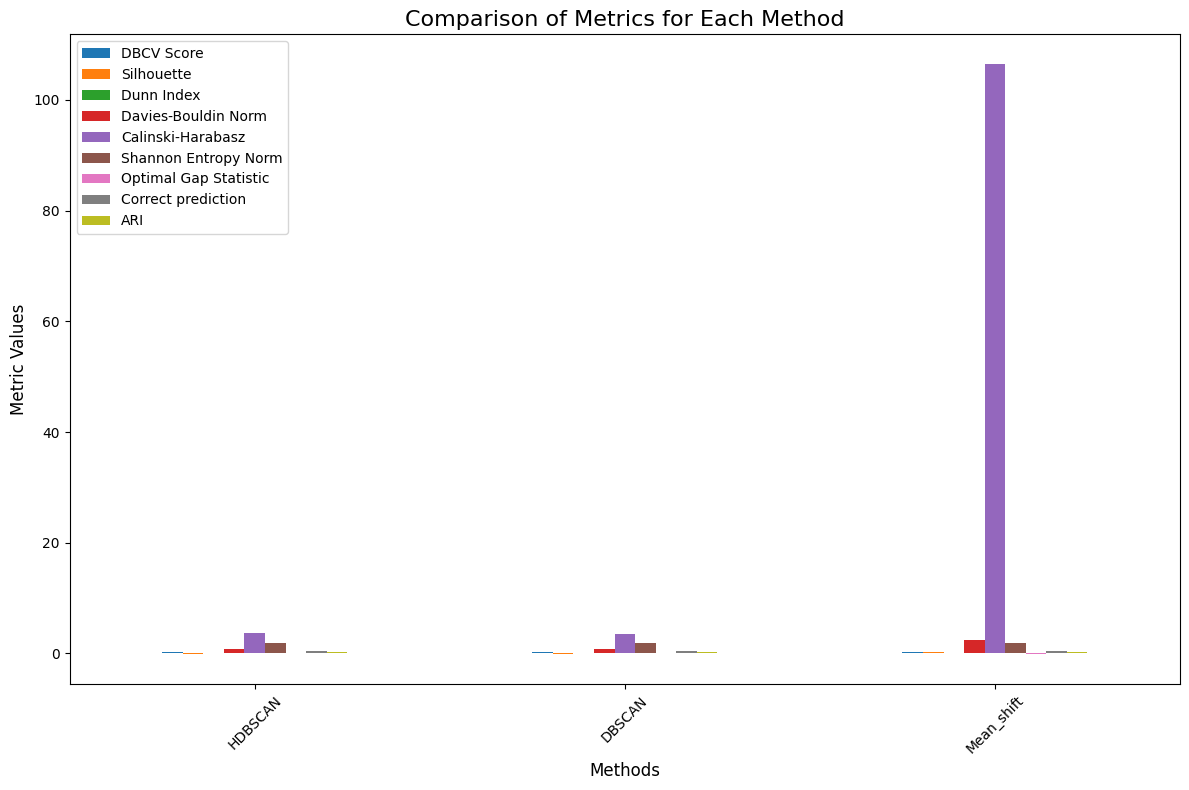

In [114]:
df_metrics.set_index("Method", inplace=True)

plt.figure(figsize=(10, 8))
df_metrics.plot(kind='bar', figsize=(12, 8))
plt.title('Comparison of Metrics for Each Method', fontsize=16)
plt.xlabel('Methods', fontsize=12)
plt.ylabel('Metric Values', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#**Diabetes**

#**Sepsis**

#**Heart failure**

#**Cardiac Arrest**